In [1]:
%matplotlib notebook
import numpy as np
import twentyonecmfast_tools as tt
import matplotlib.pyplot as plt
import glob
from astropy.cosmology import WMAP9 as cosmo
import os
from scipy.ndimage import filters
from scipy.interpolate import interp1d
import time
from astropy import constants as const
from matplotlib.colors import LogNorm, SymLogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
from matplotlib.colors import SymLogNorm
import time

In [2]:
# Preliminaries and options before running everything
t0 = time.time()
data_dir = '/data4/beards/HERA_msip_plots/'
plotdir = data_dir + 'plots/'
infiles = [data_dir + f for f in ['delta_T_z7_nf0.10_21cmFAST_1024_1000Mpc', 'delta_T_z7_nf0.10_21cmFAST+Fcoll+MFP_1024_1000Mpc']]
data_dir2 = '/data4/beards/21cmFAST/Boxes/'
infiles += [data_dir2 + 'delta_T_v3_no_halos_z0' + etc for etc in ['06.58_nf0.161025_useTs1_zetaX2.0e+56_alphaX1.2_TvirminX3.0e+04_aveTb002.27_Pop2_512_600Mpc',
                                                                   '07.04_nf0.302255_useTs1_zetaX2.0e+56_alphaX1.2_TvirminX3.0e+04_aveTb004.73_Pop2_512_600Mpc',
                                                                   '07.53_nf0.458741_useTs1_zetaX2.0e+56_alphaX1.2_TvirminX3.0e+04_aveTb007.83_Pop2_512_600Mpc',
                                                                   '08.06_nf0.599685_useTs1_zetaX2.0e+56_alphaX1.2_TvirminX3.0e+04_aveTb010.91_Pop2_512_600Mpc',
                                                                   '08.80_nf0.737095_useTs1_zetaX2.0e+56_alphaX1.2_TvirminX3.0e+04_aveTb013.78_Pop2_512_600Mpc',
                                                                   '09.82_nf0.849877_useTs1_zetaX2.0e+56_alphaX1.2_TvirminX3.0e+04_aveTb013.94_Pop2_512_600Mpc',
                                                                   '10.71_nf0.907356_useTs1_zetaX2.0e+56_alphaX1.2_TvirminX3.0e+04_aveTb008.69_Pop2_512_600Mpc']]
run_names = ['Vanilla', 'NewAbsorption', 'Vanilla_z6.58', 'Vanilla_z7.04', 'Vanilla_z7.53', 'Vanilla_z8.06',
             'Vanilla_z8.80', 'Vanilla_z9.82', 'Vanilla_z10.71']
run_zs = [7.0, 7.0, 6.58, 7.04, 7.53, 8.06, 8.80, 9.82, 10.71]

## Options
run_ind = 1  # Which cube to use
bw = 10.0  # MHz
umax = 600  # meters
fov = np.deg2rad(10)
ndays = 225
wedge_mode = 'fov'
weighting = 'wiener'
mask_zero_modes = True
kz_buffer = 0
kperp_buffer = 0

# wedge_mode options are:
#     'horizon' - mask everything above the horizon
#     'half_sky' - mask everything above pi/4 above horizon
#     'twice_fov' - mask everything within 2x fov
#     'fov' - mask within fov
#     'no' - no wedge mask
# weighting options are:
#     'uniform' - uniform weighting
#     'natural' - natural weighting
#     'wiener' - use wiener filter

In [3]:
def calc_FT_cube(incube, x, y, z, invert=False):
    """
    Function to FT cube and calculate k axes.
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        invert: Invert FT (go back to image space). Default False.
        
    Returns:
        FT_cube: 3D cube, the fourier transform of incube. No jacobian is applied.
        kx: 1D array of kx coordinates. Units Mpc^-1.
        ky: 1D array of ky coordinates. Units Mpc^-1.
        kz: 1D array of kz coordinates. Units Mpc^-1.
    """
    
    if invert:
        FT_cube = np.fft.ifftn(np.fft.ifftshift(incube))
    else:
        FT_cube = np.fft.fftshift(np.fft.fftn(incube))
    
    # Get k-axes
    dkx = 2 * np.pi / (x.max() - x.min())
    dky = 2 * np.pi / (y.max() - y.min())
    dkz = 2 * np.pi / (z.max() - z.min())
    kx = dkx * (np.arange(len(x)) - len(x) / 2)
    ky = dky * (np.arange(len(y)) - len(y) / 2)
    kz = dkz * (np.arange(len(z)) - len(z) / 2)
    
    return FT_cube, kx, ky, kz

In [4]:
def calc_PS_3d(incube, x, y, z):
    """
    Function to calculate 3D power spectrum from an input cube
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        
    Returns:
        PS: 3D power spectrum. If inputcube is in mK, PS is in mK^2 Mpc^3
        kx: 1D array of kx coordinates. Units Mpc^-1.
        ky: 1D array of ky coordinates. Units Mpc^-1.
        kz: 1D array of kz coordinates. Units Mpc^-1.
    """
    # Get 3D PS
    PS, kx, ky, kz = calc_FT_cube(incube, x, y, z)
    jacobian = np.mean(np.diff(x)) * np.mean(np.diff(y)) * np.mean(np.diff(z))
    PS = np.abs(jacobian * PS)**2. / (x.max() - x.min()) / (y.max() - y.min()) / (z.max() - z.min())


    return PS, kx, ky, kz

In [5]:
def calc_PS_1d(incube, x, y, z, k_bin=1):
    """
    Function to calculate 1D power spectrum from an input cube
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        k_bin: Factor by which to bin up k. Default 1.
        
    Returns:
        PS: 1D power spectrum. If inputcube is in mK, PS is in mK^2 Mpc^3
        k: 1D array of k coordinates. Units Mpc^-1.
    """
    # Get 3D PS
    PS_3d, kx, ky, kz = calc_PS_3d(incube, x, y, z)
    
    # Get k matrix 
    kxmat, kymat, kzmat = np.meshgrid(kx, ky, kz, indexing='ij')
    kmat = np.sqrt(kxmat**2 + kymat**2 + kzmat**2)
    
    # Form output axis
    dk = np.mean([np.mean(np.diff(kx)), np.mean(np.diff(ky)), np.mean(np.diff(kz))]) * k_bin
    k = np.arange(0, kmat.max(), dk)
    k_inds = np.digitize(kmat, k - 0.5 * dk)
    
    # Bin the PS
    PS = np.zeros(len(k))
    for i in range(len(k)):
        ind = np.where(k_inds == i)
        if len(ind[0]) == 0:
            continue
        PS[i - 1] = np.mean(PS_3d[ind])

    return PS, k

In [6]:
def calc_PS_2d(incube, x, y, z, kperp_bin=1, kpar_bin=1):
    """
    Function to calculate 2D power spectrum from an input cube
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        kperp_bin: Factor by which to bin up kperp. Default 1.
        kpar_bin: Factor by which to bin up kpar. Default 1.
        
    Returns:
        PS: 2D power spectrum. If inputcube is in mK, PS is in mK^2 Mpc^3
        kperp: 1D array of kperp coordinates. Units Mpc^-1.
        kpar: 1D array of kpar coordinates. Units Mpc^-1.
    """
    # Get 3D PS
    PS_3d, kx, ky, kz = calc_PS_3d(incube, x, y, z)
    
    # Get kperp matrix
    kxmat, kymat = np.meshgrid(kx, ky, indexing='ij')
    kperpmat = np.sqrt(kxmat**2 + kymat**2)
    
    # Form output axes
    dkperp = np.mean([np.mean(np.diff(kx)), np.mean(np.diff(ky))]) * kperp_bin
    kperp = np.arange(0, kperpmat.max(), dkperp)
    dkpar = np.mean(np.diff(kz)) * kpar_bin
    kz = np.abs(kz)  # Fold over
    kpar = np.arange(0, kz.max(), dkpar)
    kperpinds = np.digitize(kperpmat, kperp - 0.5 * dkperp)
    kparinds = np.digitize(kz, kpar - 0.5 * dkpar)
    kpar_ind_lookup = []
    for j in range(len(kpar)):
        ind_par = np.where(kparinds == j)[0]
        kpar_ind_lookup.append(ind_par)
    
    # Bin the PS
    PS = np.zeros((len(kperp), len(kpar)))
    for i in range(len(kperp)):
        ind_perp = np.where(kperpinds == i)
        if len(ind_perp[0]) == 0:
            continue
        for j in range(len(kpar)):
            ind_par = kpar_ind_lookup[j]
            if len(ind_par) == 0:
                continue
            PS[i - 1, j - 1] = np.mean(PS_3d[ind_perp][0, ind_par])

    return PS, kperp, kpar

In [7]:
def get_noise(FT_cube, noise_PS, jacobian, seed=None):
    """
    Get realization of random noise for a measurement cube.
    
    Args:
        FT_cube: 3D cube, in Fourier space to add noise to. (e.g. output of calc_FT_cube)
        noise_PS: 2D or 3D array of noise PS. If 2D assumes matches perp dims of FT_cube
                   and uniform in par. If 3D assumes matches all dims of FT_cube.
        jacobian: The jacobian factor used in the PS calculation. e.g. dx*dy*dz
        seed: random number seed (useful for repeatability)
    """
    np.random.seed(seed)
    Nfact = FT_cube.size
    noise_PS = np.where(np.isinf(noise_PS), 0, noise_PS)
    if len(noise_mat.shape) == 2:
        noise_PS = noise_PS[:, :, np.newaxis]
    noise = np.random.normal(size=FT_cube.shape) + 1j * np.random.normal(size=FT_cube.shape)
    noise *= np.sqrt(noise_PS * Nfact / (2. * jacobian))  # 2 for complex
    return noise

In [8]:
def hera_layout(nrings=10, dither=True, outriggers=False):
    """
    Create antenna positions for hex with given number of rings
    
    Args:
        rings: number of rings to make up array.
        dither: Whether to dither the core.
        
    Returns:
        ant_locs: 2D array of antenna locations in meters.
    """
    ndish = np.sum(np.arange(nrings + 1) * 6) + 1
    if outriggers:
        ndish += 12 + 18
    locs = np.zeros((ndish, 2))
    dE = 14.61
    dN = dE * np.cos(np.pi / 6)
    
    ant = 1
    for ring in (np.arange(nrings) + 1):
        curE = -ring * dE
        curN = 0
        locs[ant, :] = [curE, curN]
        locs[ant + 1, :] = [-curE, curN]
        ant += 2
        for row in range(ring):
            curE += 0.5 * dE
            curN += dN
            locs[ant, :] = [curE, curN]
            locs[ant + 1, :] = [curE, -curN]
            locs[ant + 2, :] = [-curE, curN]
            locs[ant + 3, :] = [-curE, -curN]
            ant += 4
        for col in range(ring-1):
            curE += dE
            locs[ant, :] = [curE, curN]
            locs[ant + 1, :] = [curE, -curN]
            ant += 2
    
    if outriggers:
        for ring in (np.arange(2) + 2):
            curE = -ring * nrings * dE
            curN = 0
            locs[ant, :] = [curE, curN]
            locs[ant + 1, :] = [-curE, curN]
            ant += 2
            for row in range(ring):
                curE += 0.5 * nrings * dE
                curN += nrings * dN
                locs[ant, :] = [curE, curN]
                locs[ant + 1, :] = [curE, -curN]
                locs[ant + 2, :] = [-curE, curN]
                locs[ant + 3, :] = [-curE, -curN]
                ant += 4
            for col in range(ring-1):
                curE += nrings * dE
                locs[ant, :] = [curE, curN]
                locs[ant + 1, :] = [curE, -curN]
                ant += 2
    
    if dither:
        ind = np.where((locs[:, 1] > 0) & (locs[:, 1] > np.tan(np.deg2rad(60)) * locs[:, 0]))[0]
        locs[ind, :] += np.array([-0.5 * dE, dN / 3.])
        ind = np.where((locs[:, 0] > 0) & (locs[:, 1] < np.tan(np.deg2rad(60)) * locs[:, 0]) &
                       (locs[:, 1] > -np.tan(np.deg2rad(60)) * locs[:, 0]))
        locs[ind, :] += np.array([0, 2. * dN / 3.])

    return locs

In [9]:
# Create an observation cube
z0 = run_zs[run_ind]
f0 = 1420.0 / (z0 + 1)  # MHz
# bw set in options

band = np.arange(f0 - bw / 2., f0 + bw / 2., .1)  # MHz
bandz = 1420.0 / band - 1

parms = os.path.basename(infiles[run_ind]).split('_')
raw_dim = int(parms[-2])
raw_size = np.float(parms[-1][0:-3])  # Box size in Mpc
raw_cube = np.fromfile(infiles[run_ind], dtype=np.float32).reshape((raw_dim, raw_dim, raw_dim))
raw_axis = np.linspace(start=0, stop=raw_size, num=raw_dim)
obs_zaxis = cosmo.comoving_distance(bandz).value

# Grab observed line-of-sight bins
hybrid_cube = np.zeros((raw_dim, raw_dim, len(obs_zaxis)), dtype=np.float32)
pix1 = map(int, np.floor(obs_zaxis / (raw_size / raw_dim)) % raw_dim)
wp1 = obs_zaxis / (raw_size / raw_dim) - np.floor(obs_zaxis / (raw_size / raw_dim))
pix2 = map(int, np.ceil(obs_zaxis / (raw_size / raw_dim)) % raw_dim)
wp2 = 1 - wp1

for i, z in enumerate(obs_zaxis - obs_zaxis.min()):
    slice1 = raw_cube[:, :, pix1[i]]
    slice2 = raw_cube[:, :, pix2[i]]
    hybrid_cube[:, :, i] = slice1 * wp1[i] + slice2 * wp2[i]

raw_cube_file = data_dir + run_names[run_ind]

<IPython.core.display.Javascript object>


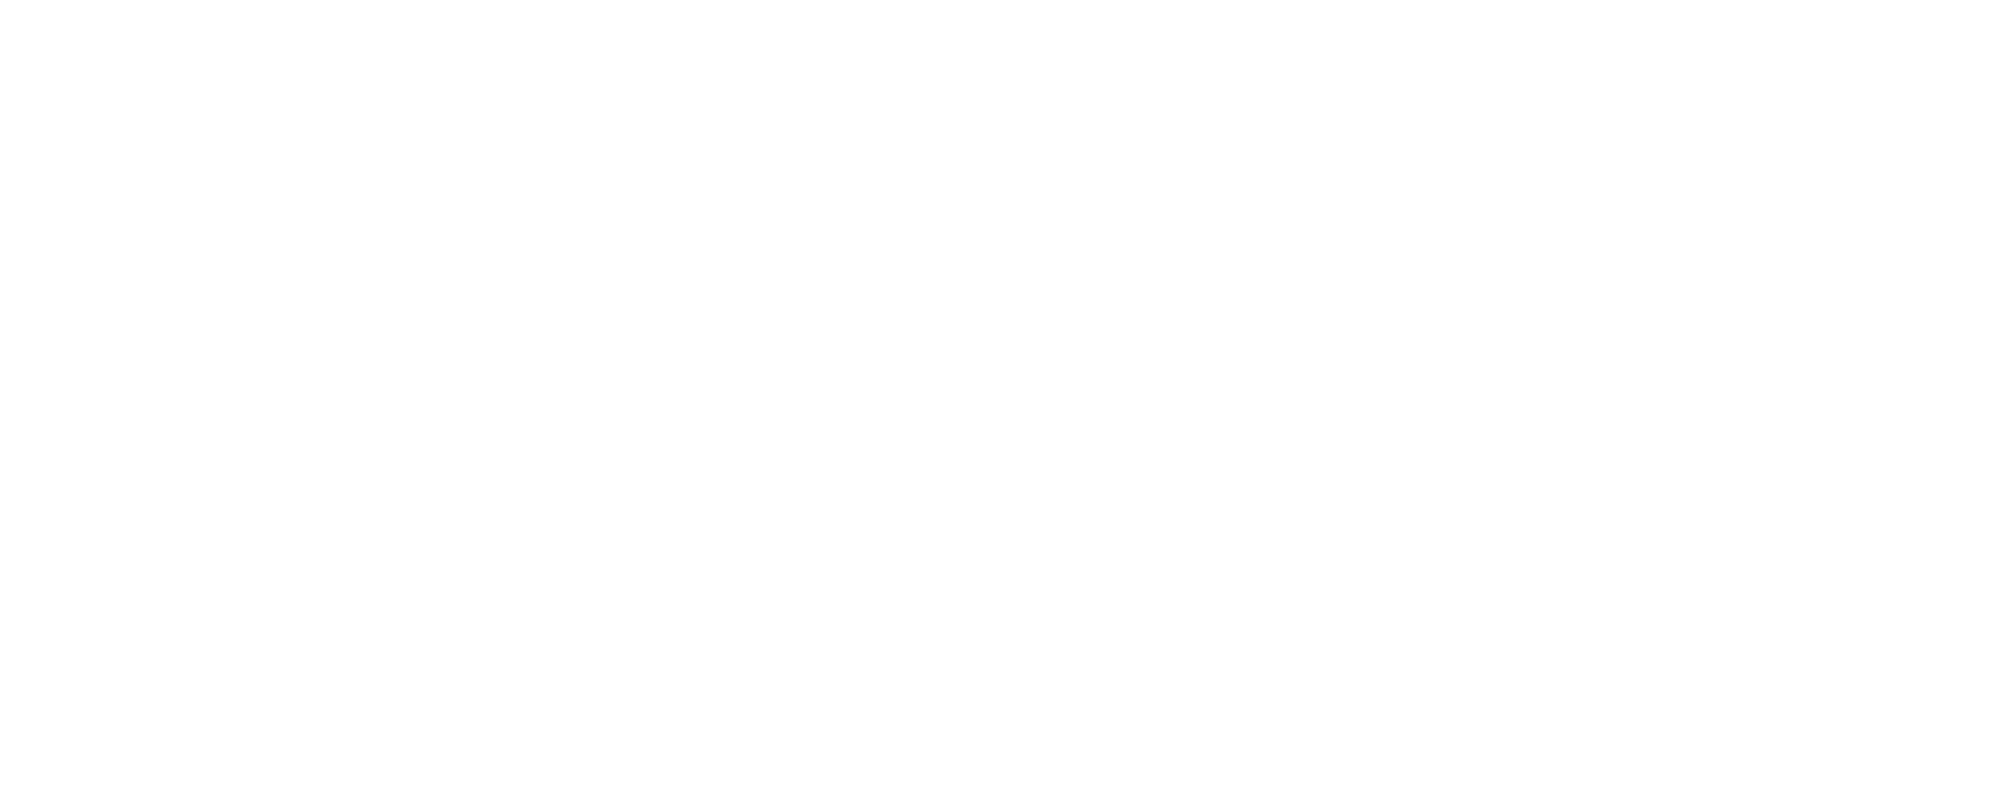

In [10]:
# Plot obs cube
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(hybrid_cube[:, :, len(band)/2], aspect='auto')
plt.subplot(132)
plt.imshow(hybrid_cube[:, raw_dim/2, :], aspect='auto')
plt.subplot(133)
plt.imshow(hybrid_cube[raw_dim/2, :, :], aspect='auto')

In [11]:
# Angular size of transverse section
print('angular extent = ' + str(np.rad2deg(raw_axis[-1] / obs_zaxis[len(band) / 2])) + ' deg')
print('angular resolution = ' + str(np.rad2deg((raw_axis[1] - raw_axis[0]) / obs_zaxis[len(band) / 2]) * 60) + ' arcmin')

angular extent = 6.47533941078 deg
angular resolution = 0.379785302685 arcmin


In [12]:
# Smooth and downsample cube in transverse direction
dperp = raw_axis[1] - raw_axis[0]
conv_cube = np.zeros_like(hybrid_cube)
sig = obs_zaxis * const.c.to('m/s').value / (band * 1e6 * umax) / 2.
minsig = int(0.85 * np.round(sig.min()))  # keep a little extra resolution
downlen = (len(np.arange(0, hybrid_cube.shape[0], minsig)), len(np.arange(0, hybrid_cube.shape[1], minsig)))
downselect_cube = np.zeros((downlen[0], downlen[1], hybrid_cube.shape[2]))
for i in range(hybrid_cube.shape[-1]):
    conv_cube[:, :, i] = filters.gaussian_filter(hybrid_cube[:, :, i], [sig[i] / dperp, sig[i] / dperp], mode='wrap')
    downselect_cube[:, :, i] = conv_cube[::minsig, ::minsig, i]
pads = ((0, int(np.ceil(fov * np.max(obs_zaxis) / (dperp * minsig))) - downselect_cube.shape[0]),
        (0, int(np.ceil(fov * np.max(obs_zaxis) / (dperp * minsig))) - downselect_cube.shape[1]),
        (0, 0))
tiled_cube = np.pad(downselect_cube, pads, mode='wrap')
obs_perpaxis = np.arange(tiled_cube.shape[0]) * dperp * minsig
perpmap = np.pad(np.arange(0, len(raw_axis), minsig), pads[0], mode='wrap')
xmap = np.pad(np.arange(0, len(raw_axis), minsig), pads[0], mode='wrap')

[[ 1.          0.62818248]
 [ 0.62818248  1.        ]]


<IPython.core.display.Javascript object>


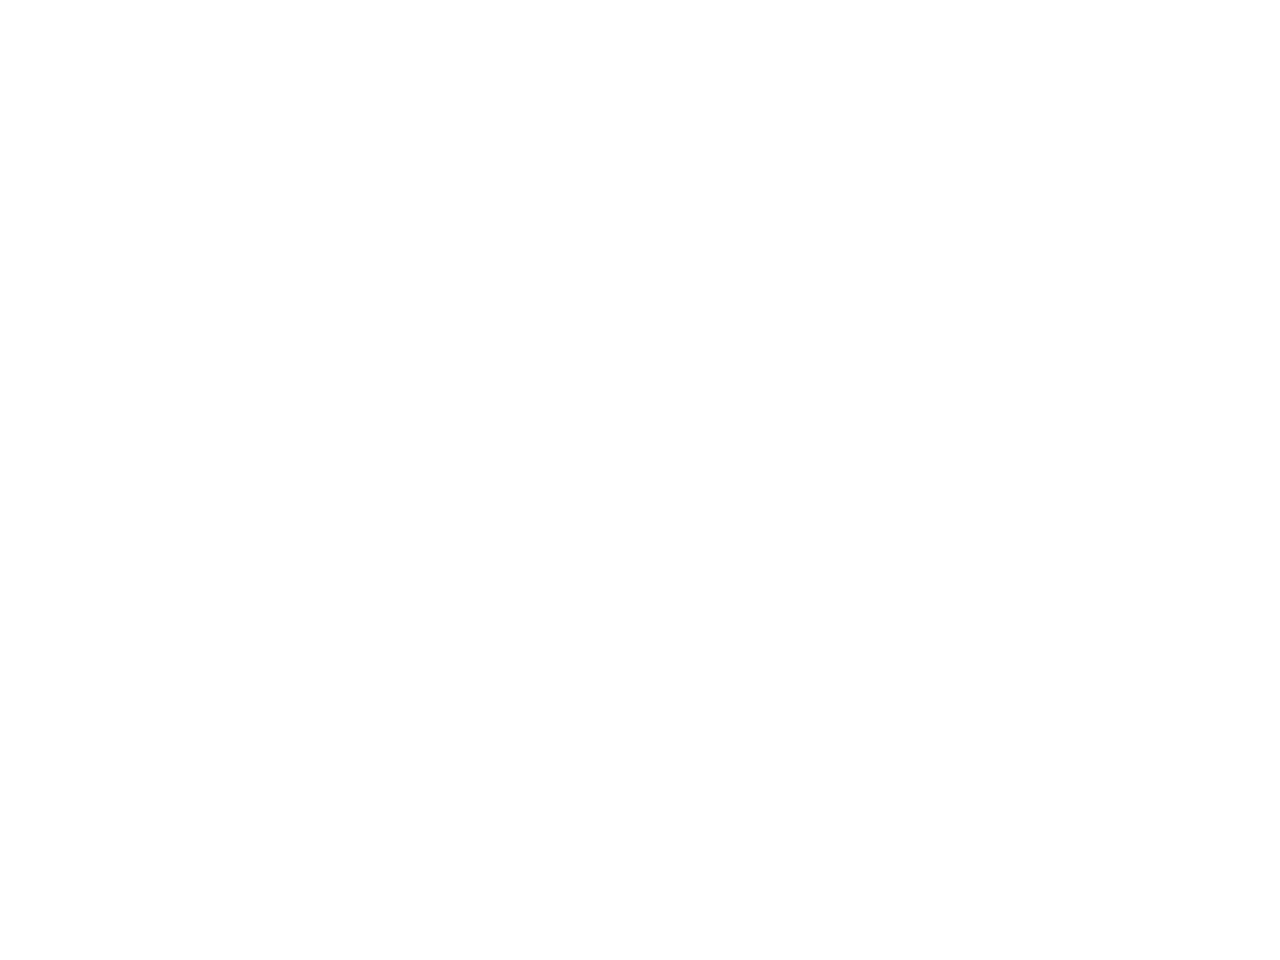

In [13]:
# Ensure xmap is constructed correctly
X, Y = np.meshgrid(xmap, xmap)
print(np.corrcoef(hybrid_cube[Y, X, :].reshape(-1), tiled_cube.reshape(-1)))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(hybrid_cube[Y, X, 50])
plt.subplot(1,2,2)
plt.imshow(tiled_cube[:, :, 50])

<IPython.core.display.Javascript object>


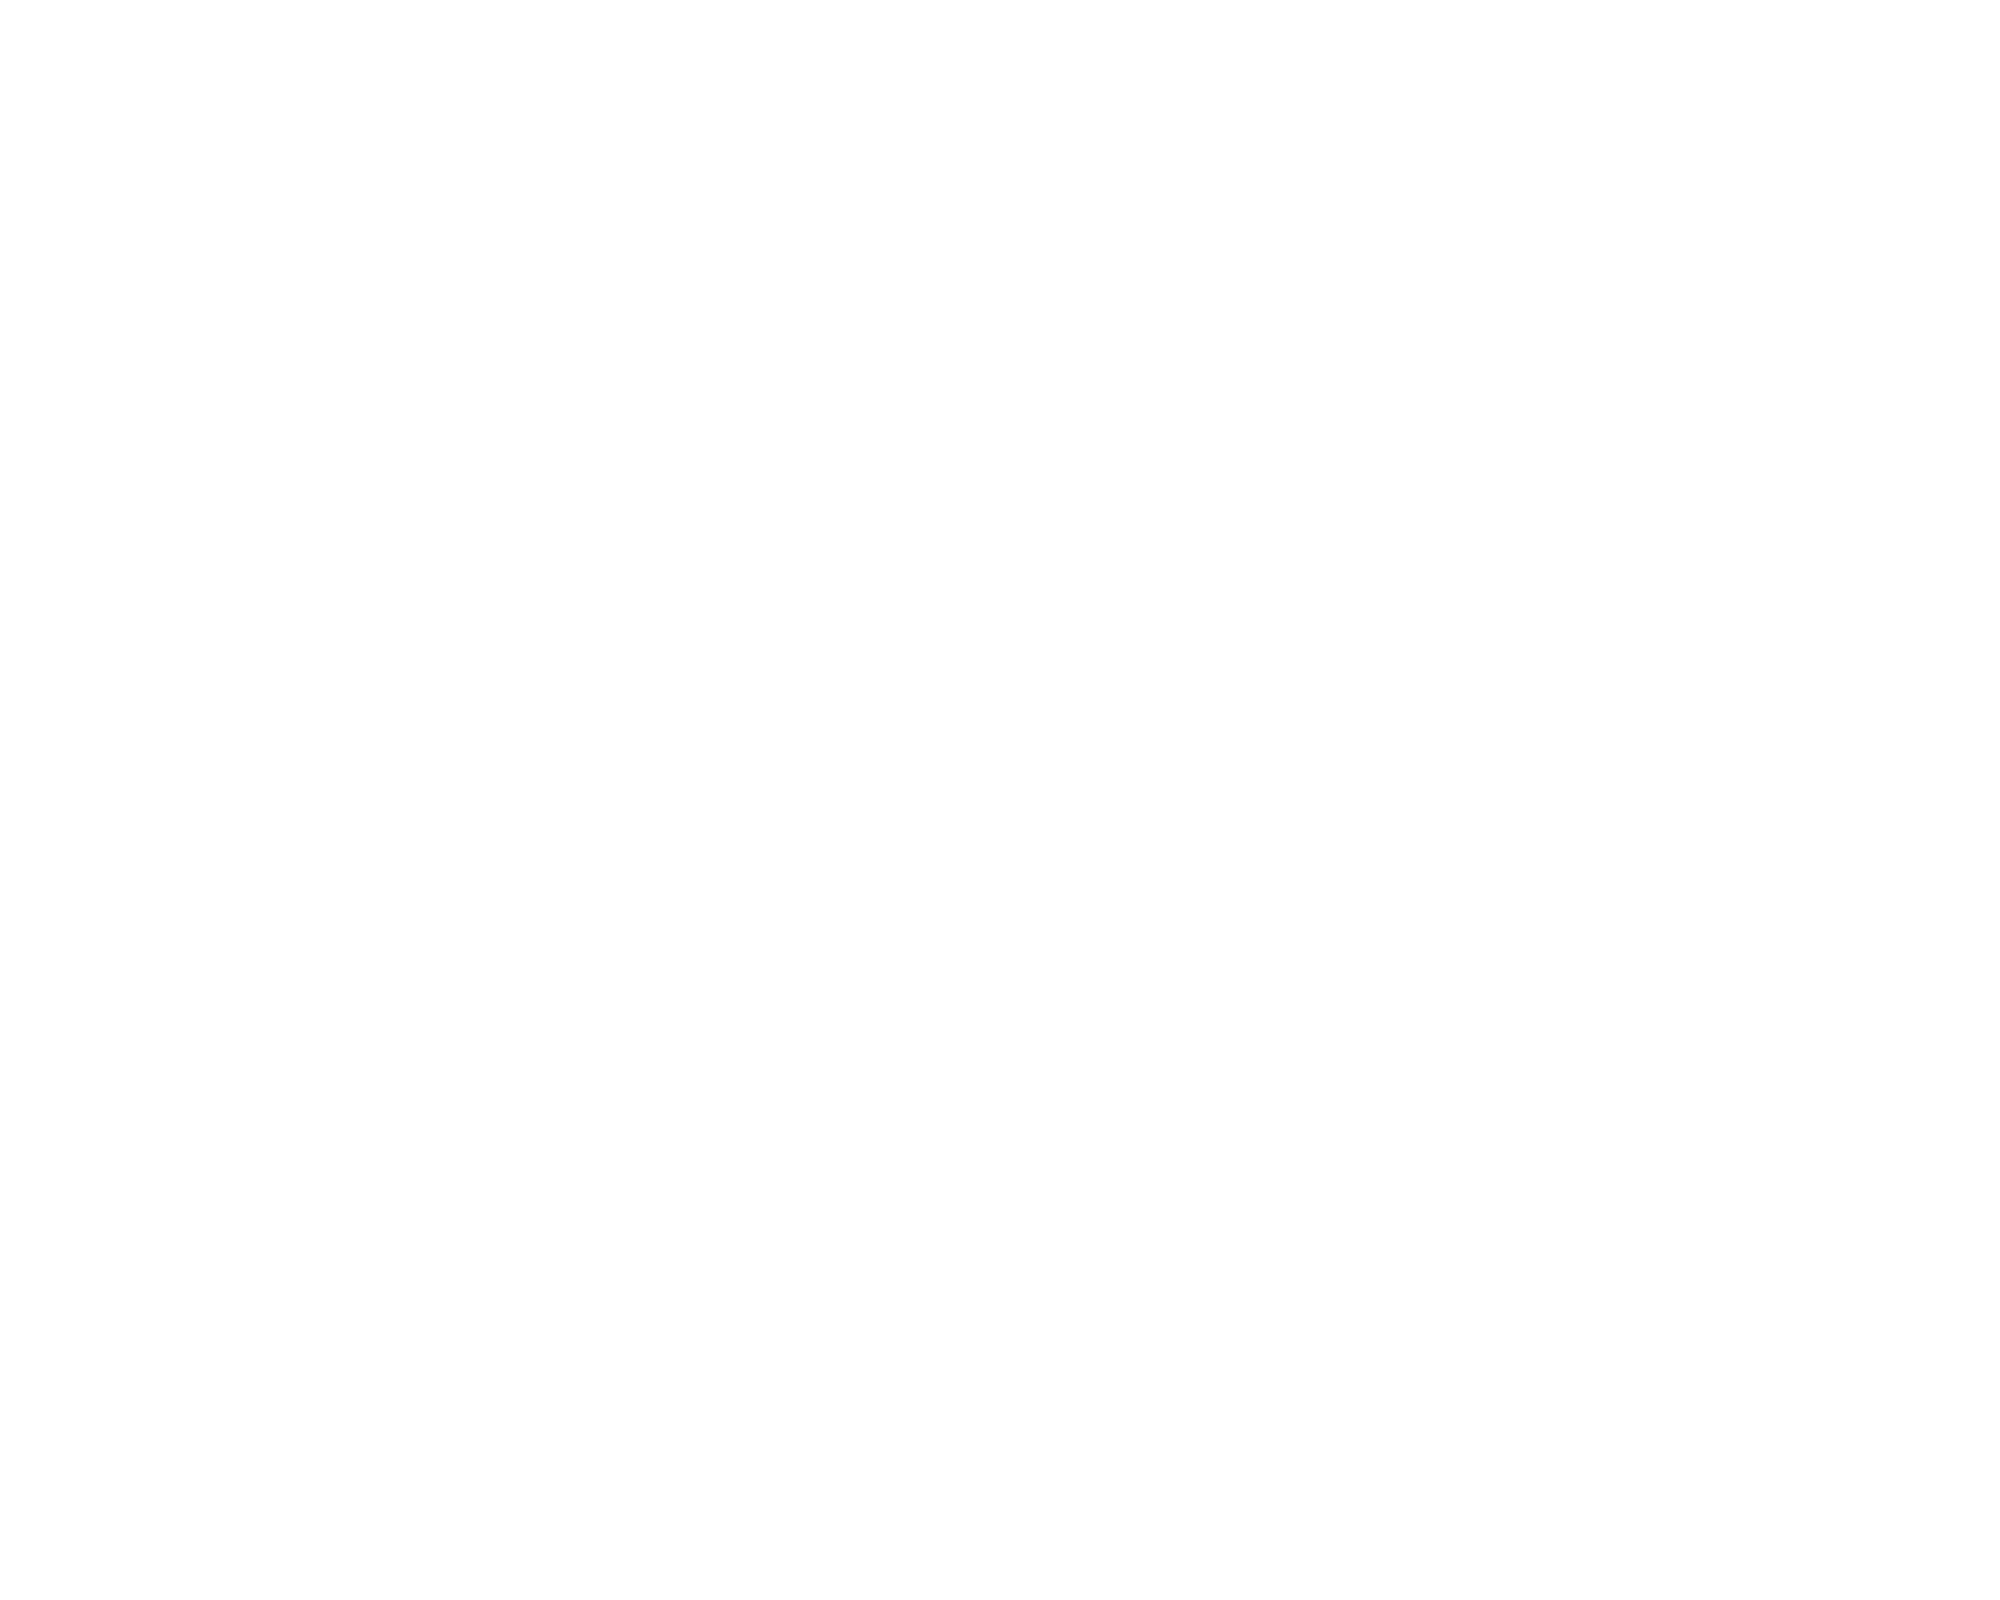

In [14]:
# Plot before/after tile/smoothing for comparison
plt.figure(figsize=(10,8))
plt.subplot(231)
plt.imshow(hybrid_cube[:, :, len(band)/2], aspect='auto')
plt.subplot(232)
plt.imshow(hybrid_cube[:, 0, :], aspect='auto')
plt.subplot(233)
plt.imshow(hybrid_cube[0, :, :], aspect='auto')
plt.subplot(234)
plt.imshow(tiled_cube[:downlen[0], :downlen[1], len(band)/2], aspect='auto')
plt.subplot(235)
plt.imshow(tiled_cube[:downlen[0], 0, :], aspect='auto')
plt.subplot(236)
plt.imshow(tiled_cube[0, :downlen[1], :], aspect='auto')

In [15]:
# FT cube, get raw PS
raw_PS, raw_k = calc_PS_1d(raw_cube, raw_axis, raw_axis, raw_axis, k_bin=10)
tiled_FT, tiled_kx, tiled_ky, tiled_kz = calc_FT_cube(tiled_cube, obs_perpaxis, obs_perpaxis, obs_zaxis)

In [16]:
# Get ideal PS for measured modes
kx_mat, ky_mat, kz_mat = np.meshgrid(tiled_kx, tiled_ky, tiled_kz, indexing='ij')
kperp_mat = np.sqrt(kx_mat**2 + ky_mat**2)
k_mat = np.sqrt(kx_mat**2 + ky_mat**2 + kz_mat**2)
f = interp1d(raw_k, raw_PS)
PS_interp = f(k_mat)

In [17]:
# Get HERA layout
antpos = hera_layout(outriggers=True)

<IPython.core.display.Javascript object>


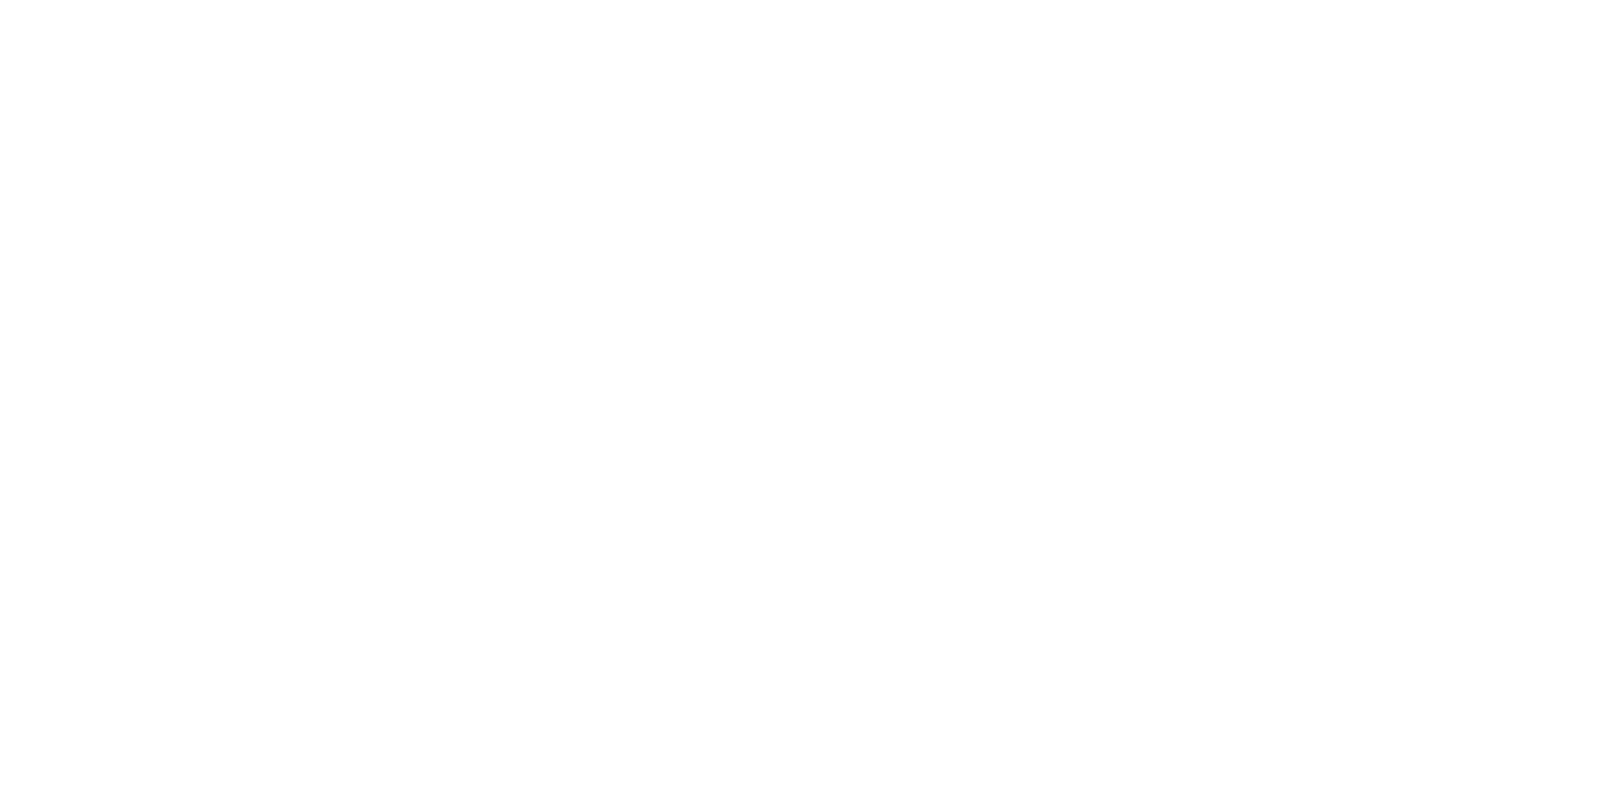

/data4/beards/src/anaconda/envs/HERA/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [18]:
# Plot HERA layout
plt.figure(figsize=(8, 4))
plt.plot(antpos[:, 0], antpos[:, 1], 'o', ms=2.5)
plt.axes().set_aspect('equal')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.savefig(plotdir + 'hera_layout.pdf')
plt.show()

In [19]:
# Get baselines
bls = []
unique_tol = 2.
for i in range(antpos.shape[0]):
    for j in range(i + 1, antpos.shape[0]):
        bl = antpos[i, :] - antpos[j, :]
        if bl[0] >= -1:
            if (bl[0] < 1) and (bl[1] < 0):
                bls.append(-bl)
            else:
                bls.append(bl)
        else:
            bls.append(-bl)
bls = np.array(bls)
bls = bls[np.linalg.norm(bls, axis=1) <= umax]
bls = np.round(bls / unique_tol)
bls, bl_counts = np.unique(bls, axis=0, return_counts=True)
bls = bls * unique_tol

<IPython.core.display.Javascript object>


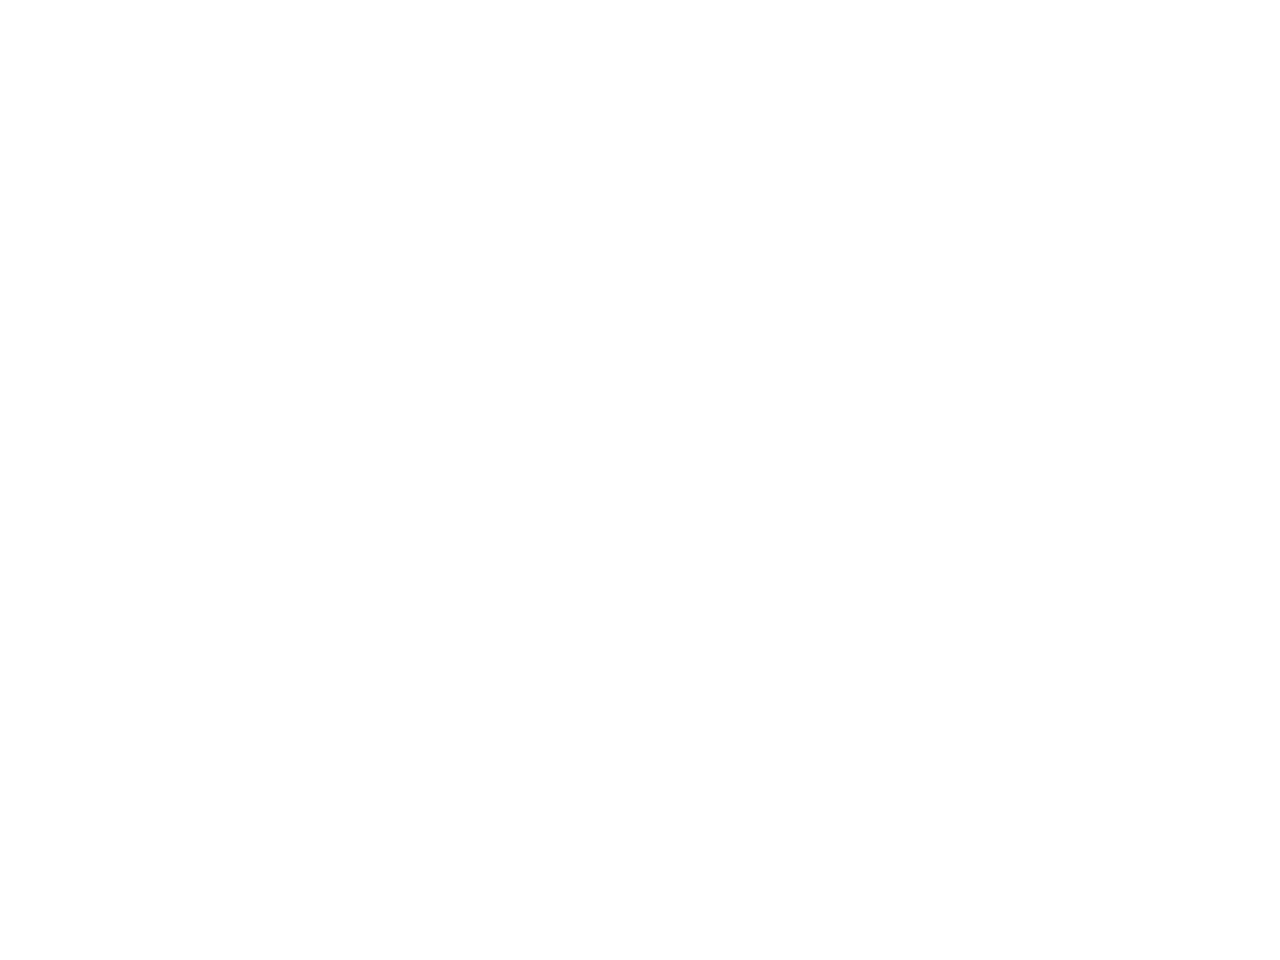

In [20]:
# Plot baseline distribution
plt.figure()
plt.scatter(bls[:, 0], bls[:, 1], c=np.log(bl_counts), s=2)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.axes().set_aspect('equal')
plt.savefig(plotdir + 'hera_baselines.pdf')

In [21]:
# Noise estimate
time_length = (fov / 2) / (2 * np.pi) * 24. * 3600.  # seconds
dt = 1. * 60.  # seconds
time_range = np.arange(-time_length / 2, time_length / 2, dt)
# Some geo to trim down code later
latitude = -0.53619181  # rad
dec = latitude  # zen drift
sdec = np.sin(dec)
cdec = np.cos(dec)
slat = np.sin(latitude)
clat = np.cos(latitude)

B = (band[-1] - band[0]) * 1e6  # Hz
lambdas = const.c.to('m/s').value / (band * 1e6)  # m
lambda0 = lambdas.mean()
D = obs_zaxis.mean()  # Mpc
deltaD = obs_zaxis[0] - obs_zaxis[-1]  # Mpc
Aeff = 93.  # m^2 (Neben et al 2016)
Tsys = (180. * (180. / f0)**2.55 + 100.) * 1e3  # mK
factor = Tsys**2 * (D**2 * lambda0**2 / Aeff) * (deltaD / B)  # Beardsley et al 2013 (eq 2)

count_mat = np.zeros(tiled_FT.shape[0:2])
b2k = 2 * np.pi / obs_zaxis / lambdas
dkx = np.mean(np.diff(tiled_kx))
dky = np.mean(np.diff(tiled_ky))
for t in time_range:
    theta = t * np.pi / (12. * 3600.)
    # do rotation
    u_m = bls[:, 0] * np.cos(theta) - bls[:, 1] * slat * np.sin(theta)
    v_m = bls[:, 0] * sdec * np.sin(theta) + bls[:, 1] * (sdec * np.cos(theta) * slat + cdec * clat)
    for fi in range(len(band)):
        # scale u
        u = u_m * b2k[fi]
        v = v_m * b2k[fi]
        # bin
        ind = (map(int, np.round(u / dkx) - count_mat.shape[0] // 2),
               map(int, np.round(v / dky) - count_mat.shape[1] // 2))
        count_mat[ind] += bl_counts * dt

temp = np.zeros_like(count_mat)
temp = np.divide(factor, count_mat * ndays, where=count_mat > .5 * dt)
noise_mat = np.where(count_mat > .5 * dt, temp, np.inf)
noise_mat *= len(band)  # should be average over freq, not sum

<IPython.core.display.Javascript object>


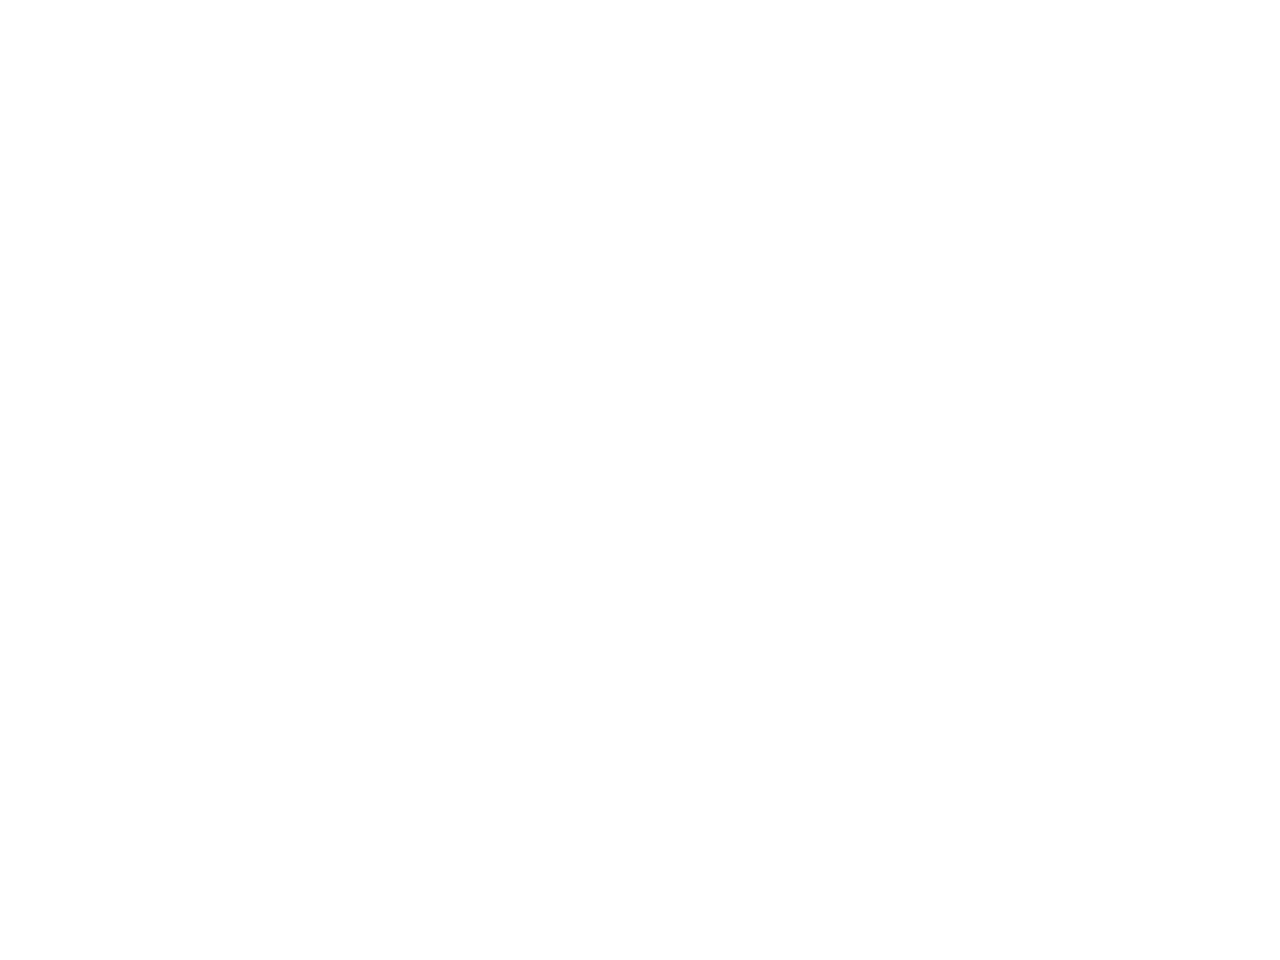

In [22]:
# Plot noise PS
plt.figure()
plt.imshow(noise_mat.T, norm=LogNorm(), vmin=1e3, vmax=1e8,
           extent=[tiled_kx.min(), tiled_kx.max(),
                   tiled_ky.min(), tiled_ky.max()])
plt.colorbar(label='mK$^2$ cMpc$^3$')
plt.xlim([0.1 * tiled_kx.min(), tiled_kx.max()])
plt.xlabel('$k_x$ (cMpc$^-1$)')
plt.ylabel('$k_y$ (cMpc$^-1$)')
plt.title('PS noise')
# plt.savefig(plotdir + 'PS_noise_' + str(int(ndays)) + '_days.pdf')
plt.savefig(plotdir + 'PS_noise_' + str(ndays) + '_days.pdf')
plt.show()

In [23]:
# Get noise
jacobian = np.abs(np.mean(np.diff(obs_zaxis)) * np.mean(np.diff(obs_perpaxis))**2.)
noise = get_noise(tiled_FT, noise_mat, jacobian, seed=2)

<IPython.core.display.Javascript object>


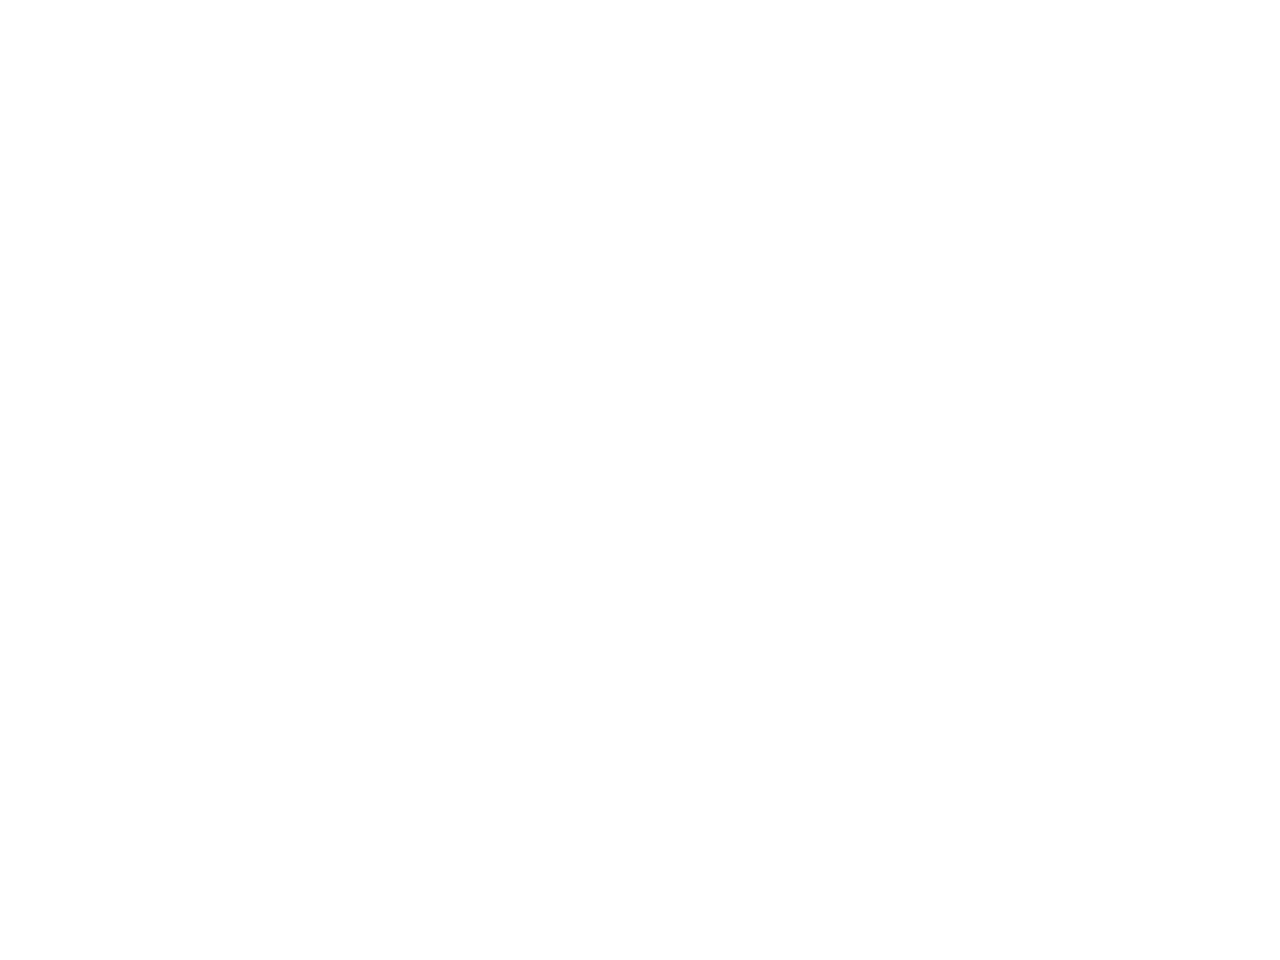

In [24]:
# Consistency check that noise is correct
plt.figure()
meas_noise_PS = (np.abs(noise)**2 * jacobian / tiled_FT.size).mean(axis=2)
plt.imshow(meas_noise_PS.T / noise_mat.T, vmin=.75, vmax=1/.75,
           extent=[tiled_kx.min(), tiled_kx.max(),
                   tiled_ky.min(), tiled_ky.max()])
plt.colorbar(label='mK$^2$ cMpc$^3$')
plt.xlim([0.1 * tiled_kx.min(), tiled_kx.max()])
plt.xlabel('$k_x$ (cMpc$^-1$)')
plt.ylabel('$k_y$ (cMpc$^-1$)')
plt.title('PS noise')
plt.show()

In [25]:
# Apply Wiener filter and FG mask
wedge_dict = {'full_sky': np.pi / 2., 'half_sky': np.pi / 4.,
              'twice_fov': fov, 'fov': fov / 2., 'no': 0,
              'horizon': np.pi / 2.}
wedge_angle = wedge_dict[wedge_mode]

if weighting == 'uniform':
    # Uniform weighting
    kfilter = np.ones_like(tiled_FT, dtype=np.float)
elif weighting == 'natural':
    # Natural weighting - downweight noisy bins
    kfilter = count_mat.reshape(noise_mat.shape + (1,)) / count_mat.max()
    kfilter = np.repeat(kfilter, PS_interp.shape[2], axis=2)
elif weighting == 'wiener':
    # Use wiener filter
    kfilter = PS_interp / (PS_interp + noise_mat.reshape(noise_mat.shape + (1,)))
else:
    raise ValueError('weighting scheme not understood')

# Next take out wedge
if wedge_mode != 'none':
    wedge_slope = (wedge_angle * cosmo.comoving_distance(z0).value /
                   cosmo.hubble_distance.value * cosmo.efunc(z0) / (1 + z0))
    kfilter[np.abs(kz_mat) < wedge_slope * kperp_mat] = 0

# Next kz=0 and kperp=0 bins + buffer
if mask_zero_modes:
    kfilter[kperp_mat <= kperp_buffer] = 0
    kfilter[np.abs(kz_mat) <= kz_buffer] = 0

<IPython.core.display.Javascript object>


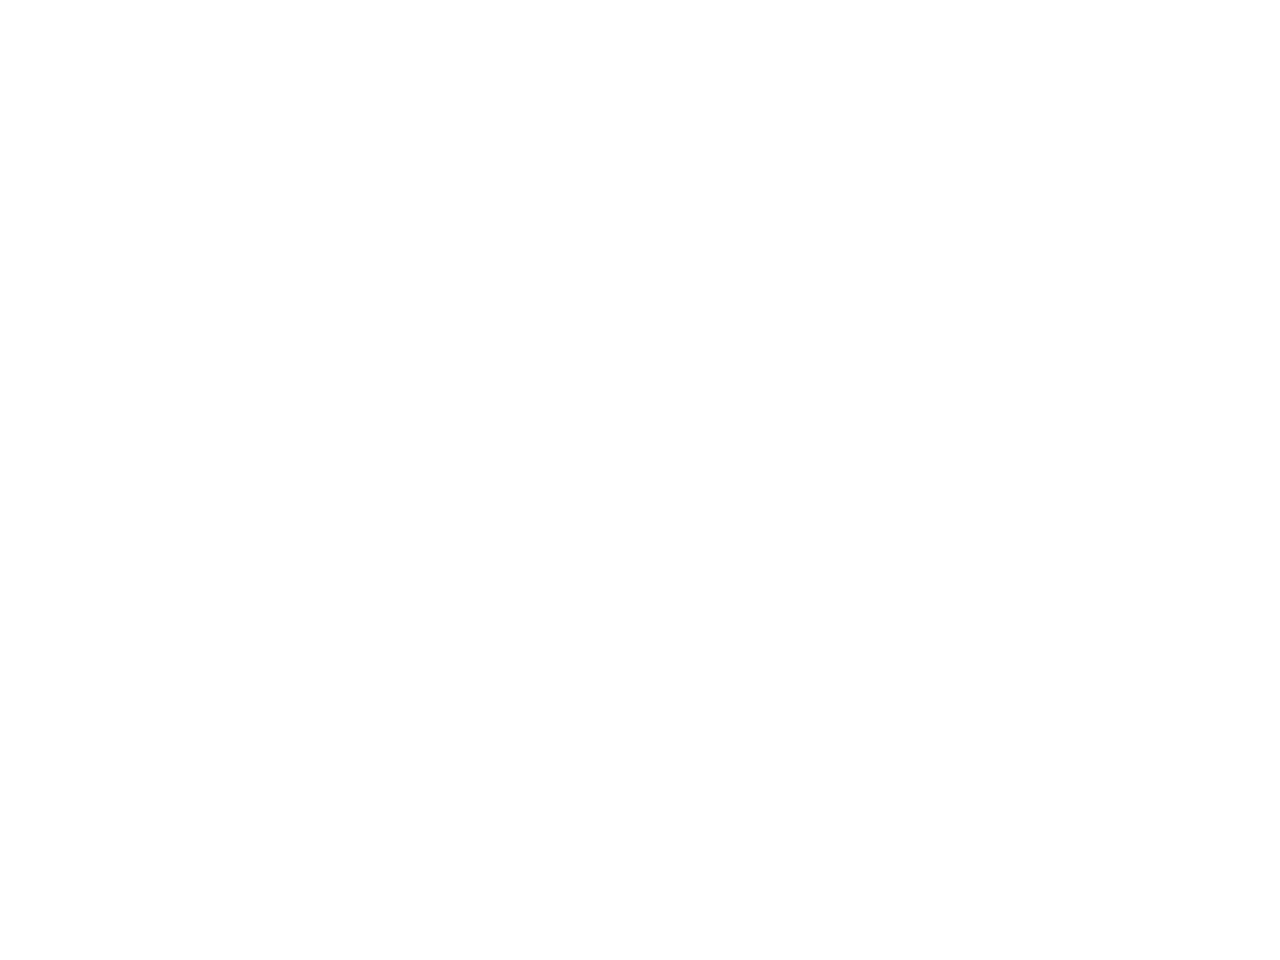

In [26]:
# Plot filter/mask
plt.figure()
plt.imshow(kfilter[:, len(tiled_kx) // 2, :].T, origin='lower', norm=LogNorm(), vmin=1e-5, vmax=1,
           extent=[tiled_kx.min(), tiled_kx.max(), tiled_kz.min(), tiled_kz.max()],
           aspect='auto')
plt.xlim([0, tiled_kx.max()])
plt.ylim([0, tiled_kz.max()])
plt.colorbar()
plt.xlabel('$k_{\perp}$ (cMpc$^-1$)')
plt.ylabel('$k_{||}$ (cMpc$^-1$)')
plt.title('Filter and Mask')
# plt.savefig(plotdir + 'Filter_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(int(ndays)) + '_days.pdf')
plt.savefig(plotdir + 'Filter_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(ndays) + '_days.pdf')
plt.show()

In [27]:
# Form images
# Note axes passed here aren't actually used.
filtered_image = np.real(calc_FT_cube(tiled_FT * kfilter, obs_perpaxis, obs_perpaxis, obs_zaxis, invert=True)[0])
filtered_noise = np.real(calc_FT_cube(noise * kfilter, obs_perpaxis, obs_perpaxis, obs_zaxis, invert=True)[0])

<IPython.core.display.Javascript object>


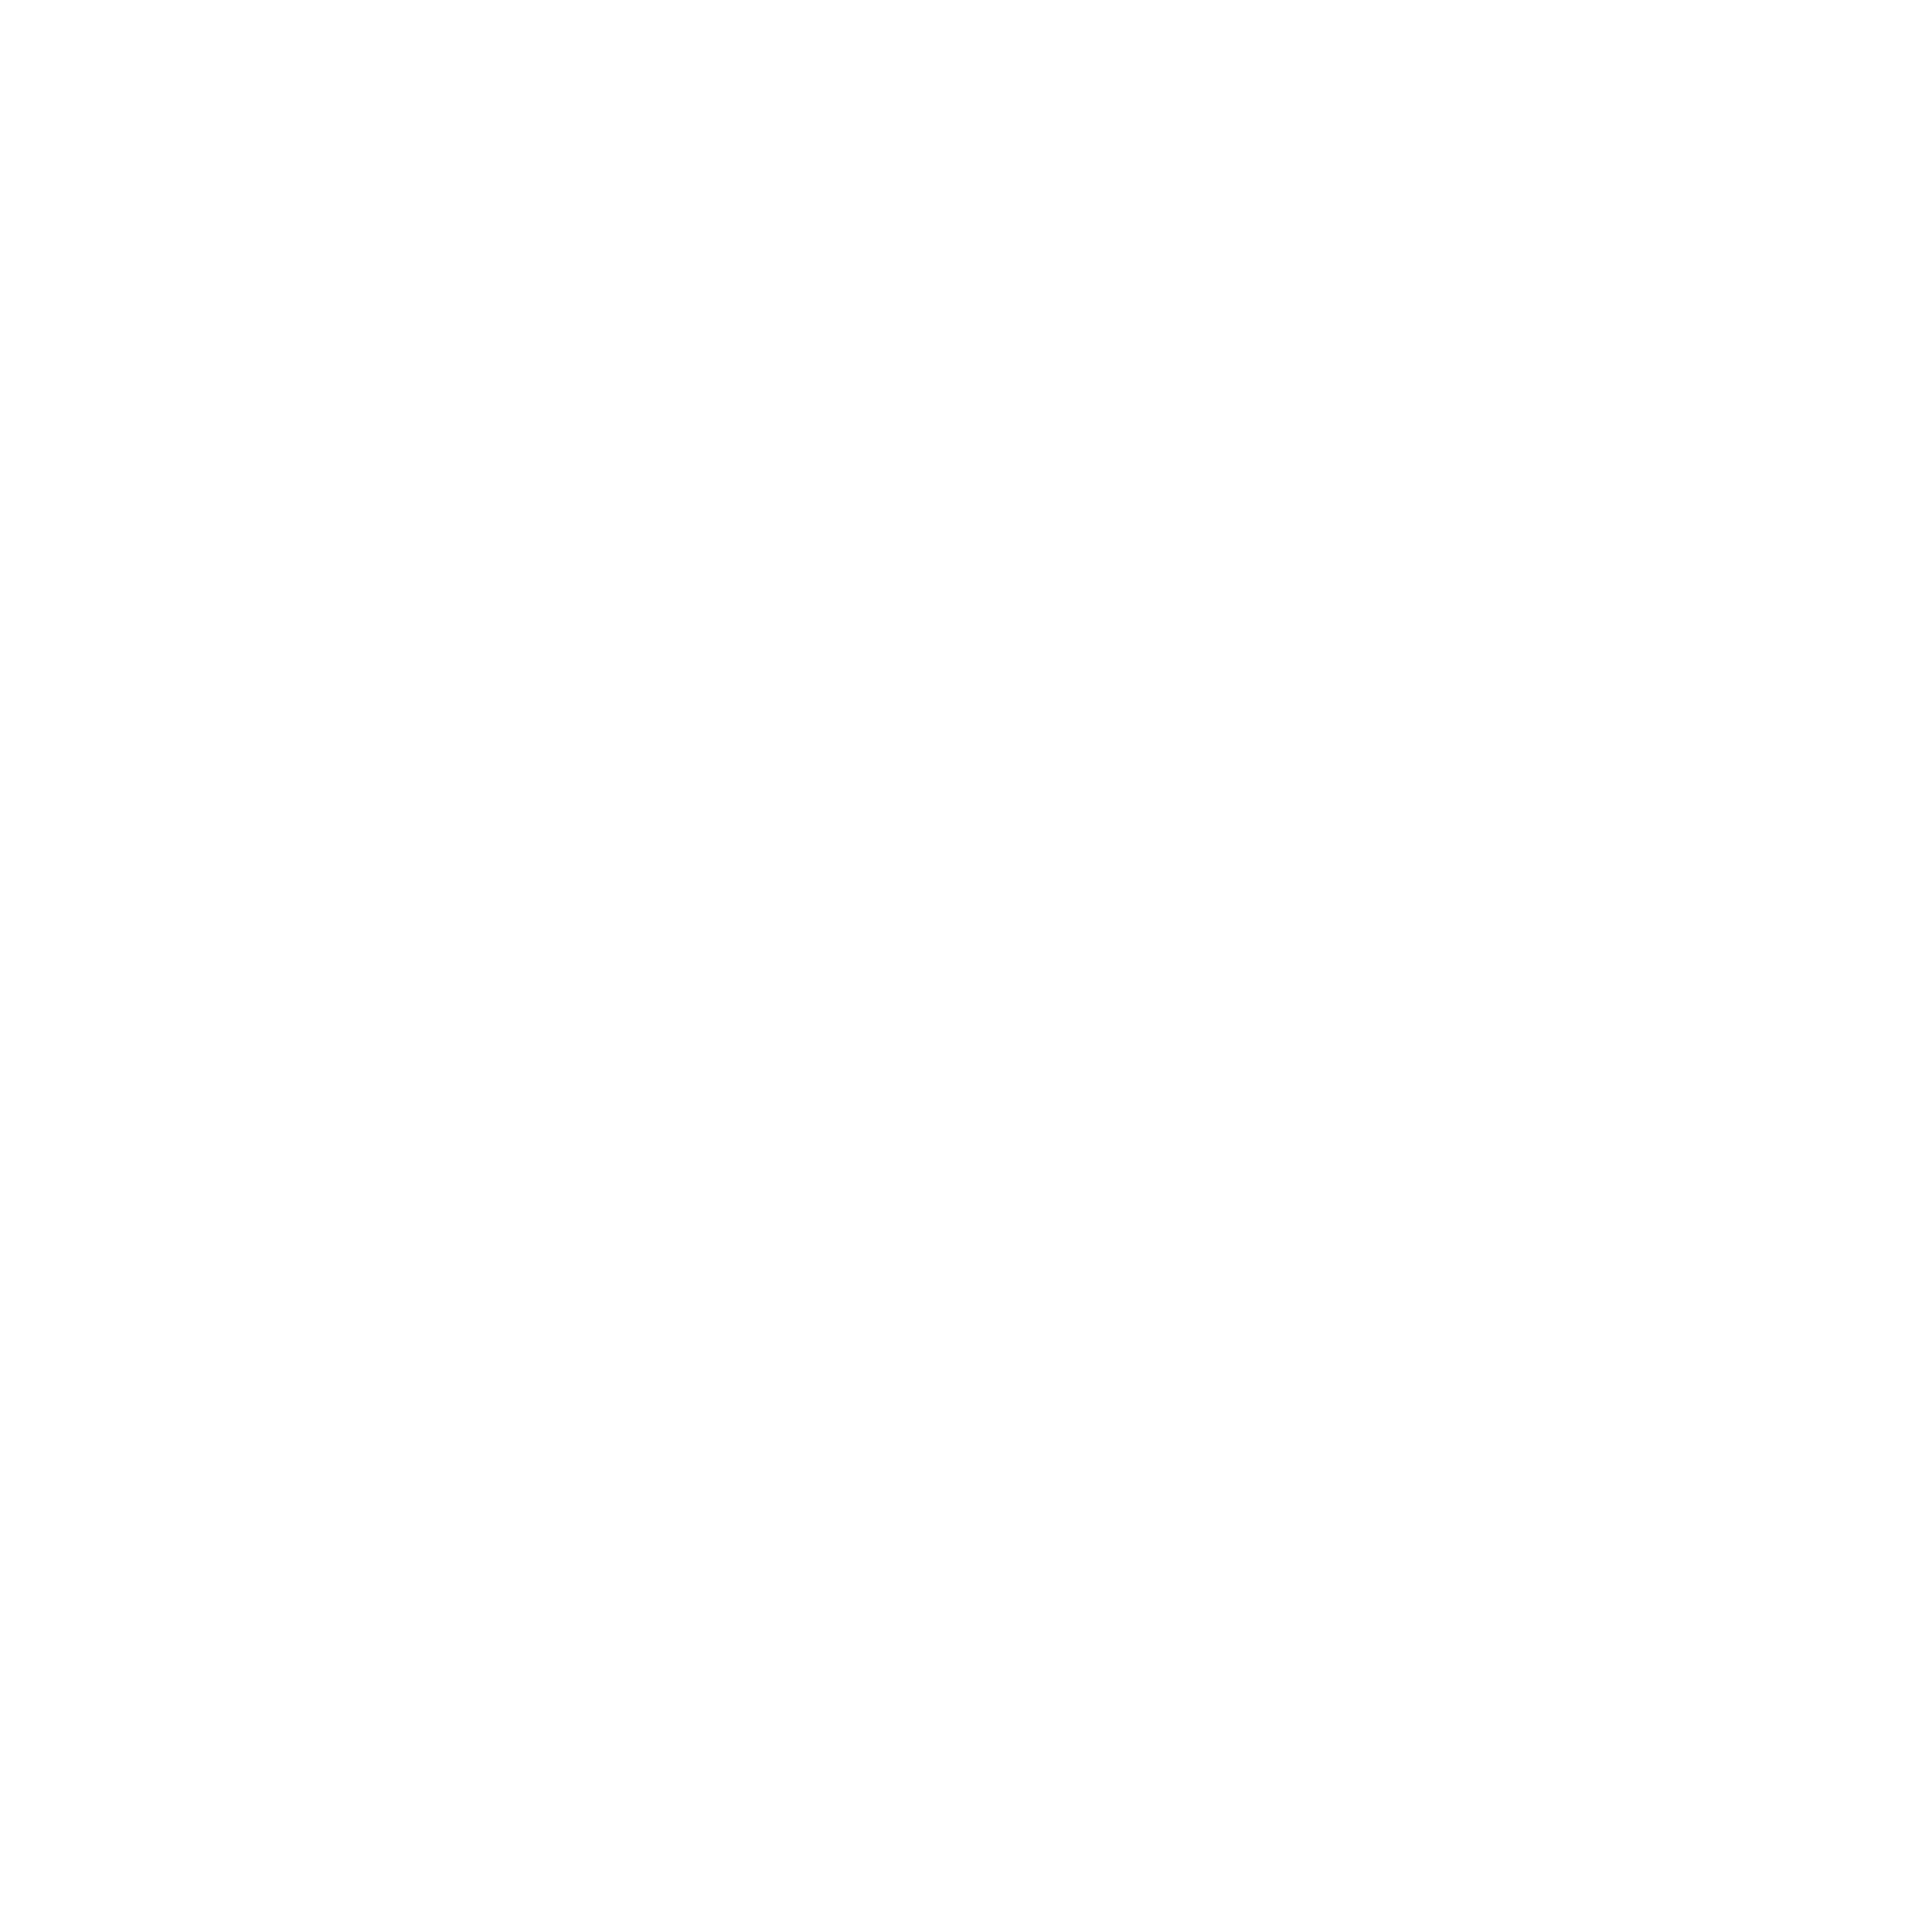

In [28]:
# Plot various images
cmap = cm.viridis
f, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 10))
ind = tiled_cube.shape[2] / 2
ext = [obs_perpaxis[0], obs_perpaxis[-1], obs_perpaxis[0], obs_perpaxis[-1]]
vmax = 0.7 * (filtered_image + filtered_noise).max()

# Raw image (smoothed, etc)
i,j = (0, 0)
im = ax[i][j].imshow(tiled_cube[:, :, ind], extent=ext, aspect='equal', cmap=cmap)
ax[i][j].set_ylabel('y (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Smoothed image')

# Filtered, no noise
i,j = (0, 1)
im = ax[i][j].imshow(filtered_image[:, :, ind], extent=ext, aspect='equal',
                     vmin=-vmax, vmax=vmax, cmap=cmap)
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Filtered, no noise')

# Just filtered noise
i,j = (1, 0)
im = ax[i][j].imshow(filtered_noise[:, :, ind], extent=ext, aspect='equal',
                     vmin=-vmax, vmax=vmax, cmap=cmap)
ax[i][j].set_xlabel('x (Mpc)')
ax[i][j].set_ylabel('y (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Filtered Noise')

# Filtered noisy
i,j = (1, 1)
im = ax[i][j].imshow((filtered_image + filtered_noise)[:, :, ind], extent=ext, aspect='equal',
                     vmin=-vmax, vmax=vmax, cmap=cmap)
ax[i][j].set_xlabel('x (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Filtered Noisy Image');

# plt.savefig(plotdir + 'Images_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(int(ndays)) + '_days.pdf')
plt.savefig(plotdir + 'Images_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(ndays) + '_days.pdf')

<IPython.core.display.Javascript object>


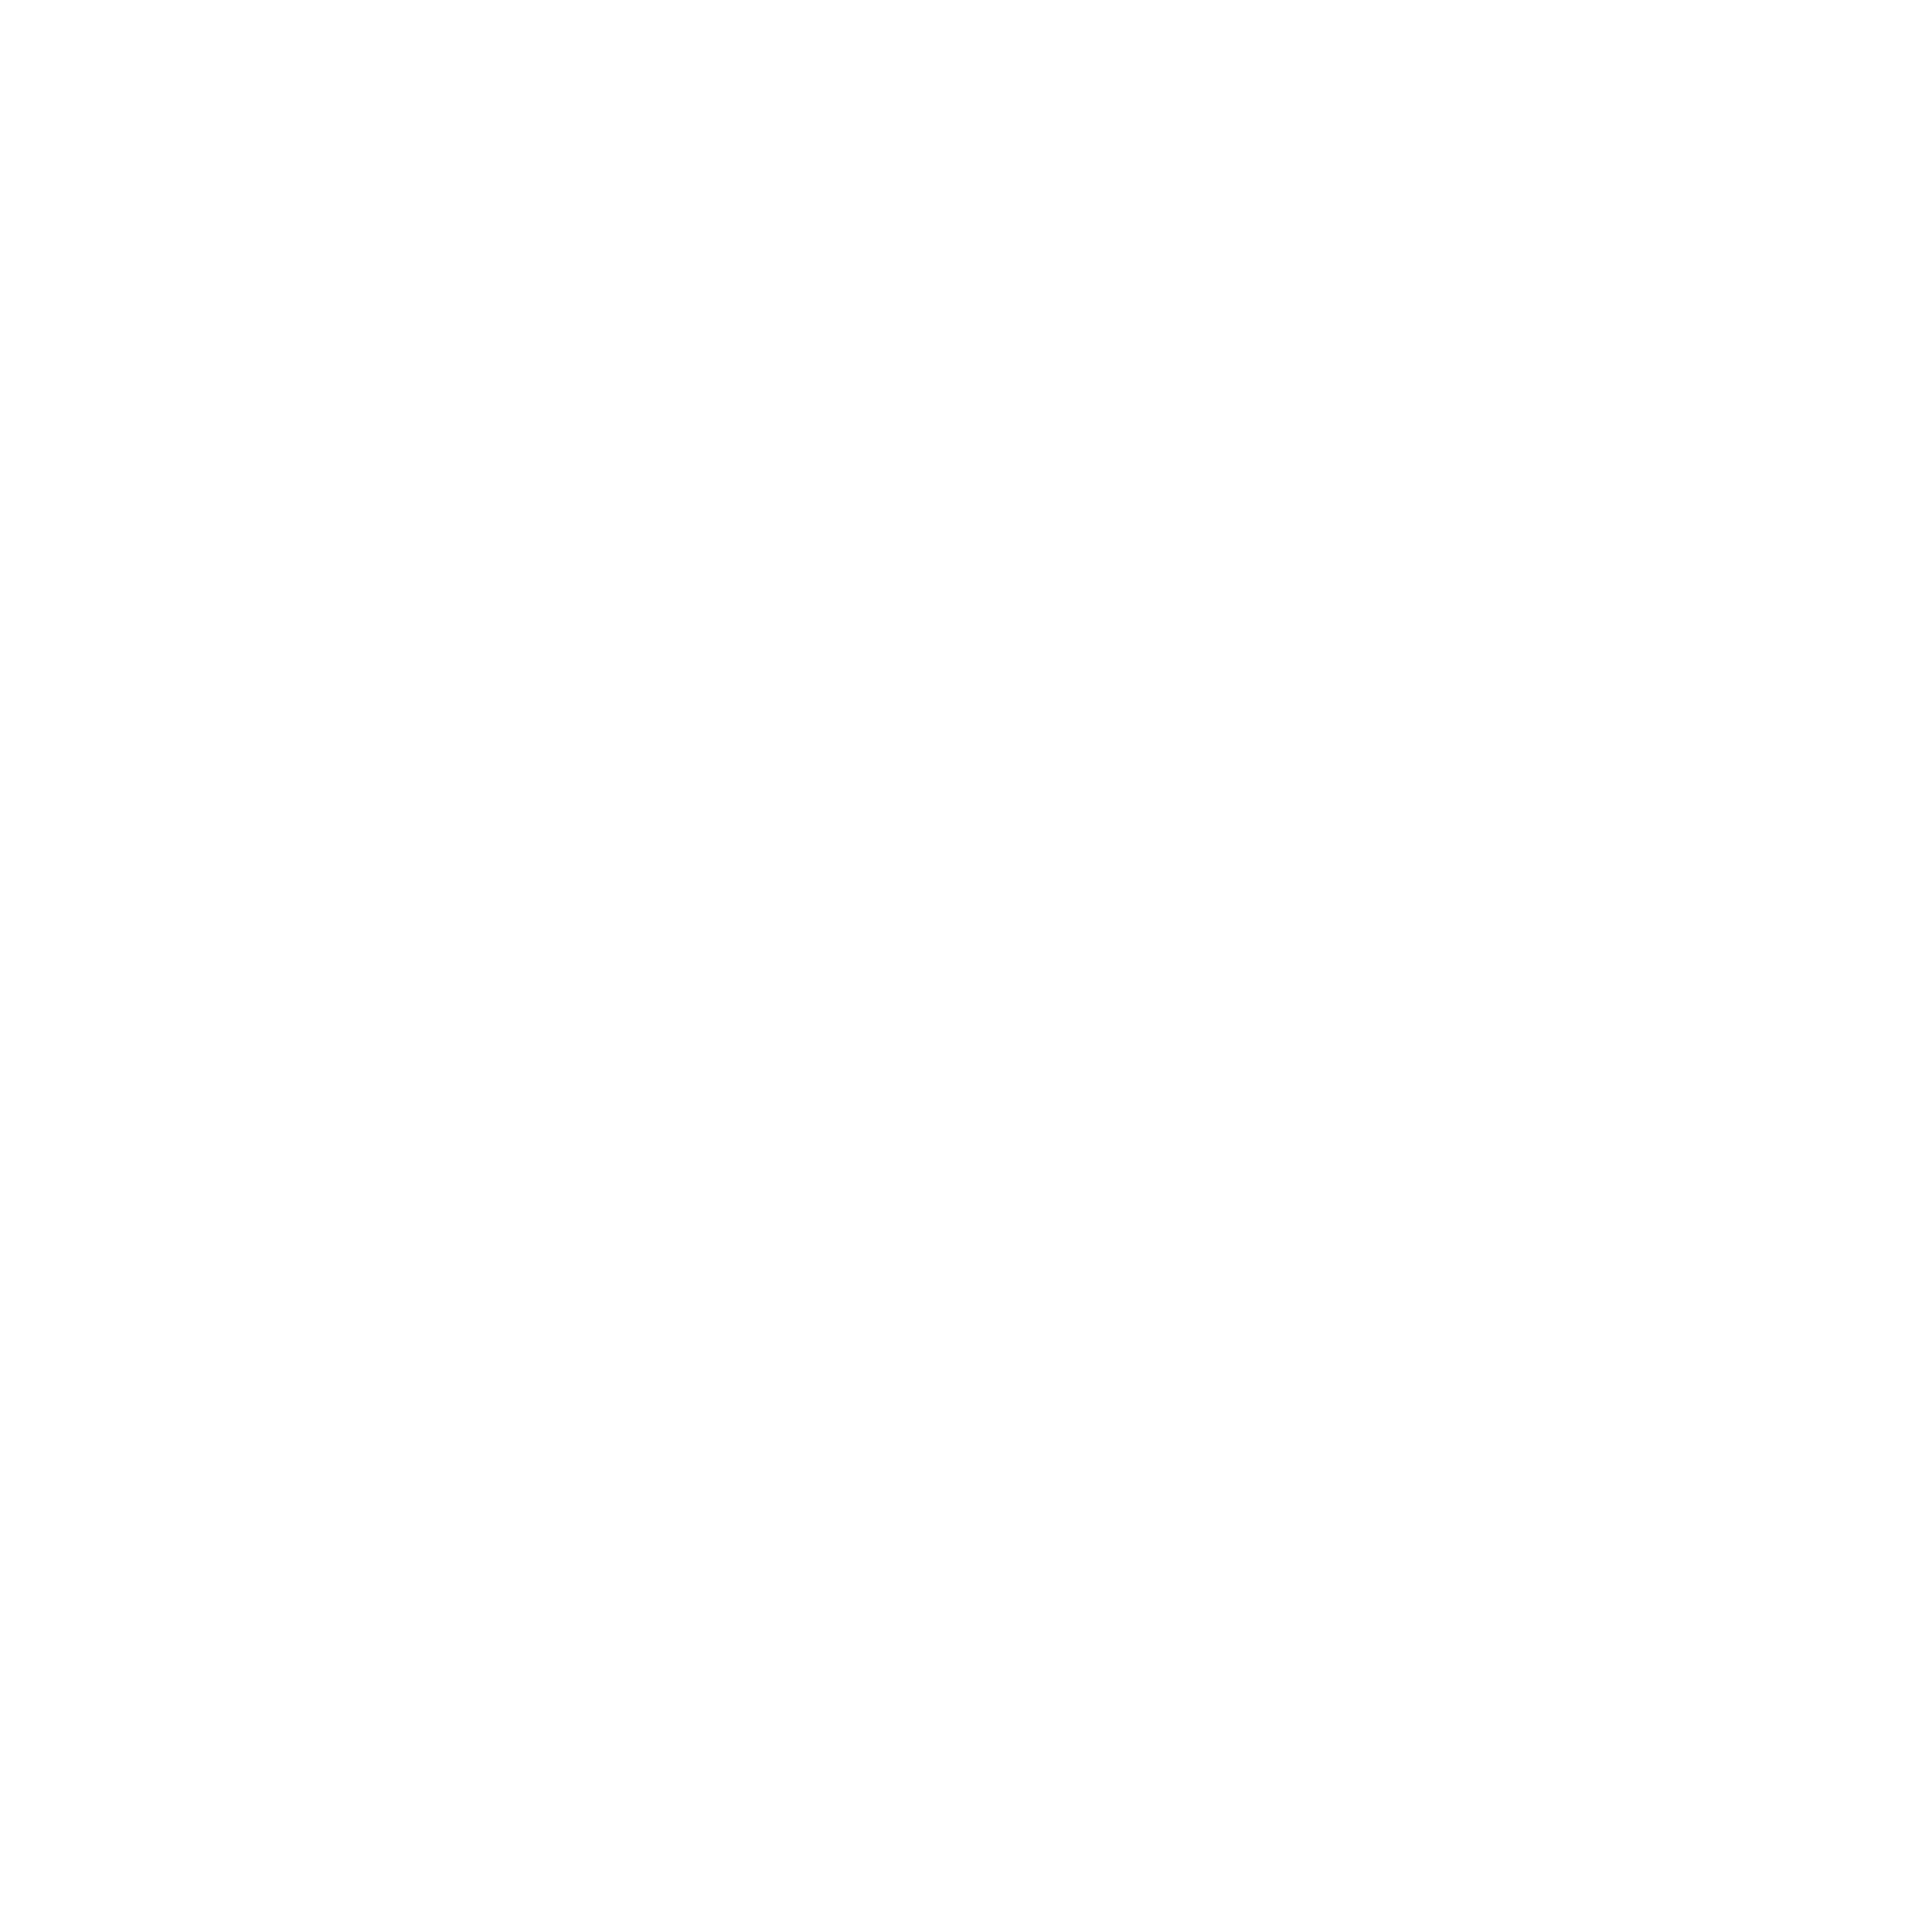

In [29]:
# Plot images, LoS cut
f, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 10))
ind = tiled_cube.shape[0] / 2
ext = [obs_zaxis[0], obs_zaxis[-1], obs_perpaxis[0], obs_perpaxis[-1]]
vmax = 0.7 * (filtered_image + filtered_noise).max()

# Raw image (smoothed, etc)
i,j = (0, 0)
im = ax[i][j].imshow(tiled_cube[ind, :, :], extent=ext, aspect='auto')
ax[i][j].set_ylabel('x (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Smoothed image')

# Filtered, no noise
i,j = (0, 1)
im = ax[i][j].imshow(filtered_image[ind, :, :], extent=ext, aspect='auto',
                     vmin=-vmax, vmax=vmax)
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Filtered, no noise')

# Just filtered noise
i,j = (1, 0)
im = ax[i][j].imshow(filtered_noise[ind, :, :], extent=ext, aspect='auto',
                     vmin=-vmax, vmax=vmax)
ax[i][j].set_xlabel('z (Mpc)')
ax[i][j].set_ylabel('x (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Filtered Noise')

# Filtered noisy
i,j = (1, 1)
im = ax[i][j].imshow((filtered_image + filtered_noise)[ind, :, :], extent=ext, aspect='auto',
                     vmin=-vmax, vmax=vmax)
ax[i][j].set_xlabel('z (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Filtered Noisy Image');

# plt.savefig(plotdir + 'ImagesLoS_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(int(ndays)) + '_days.pdf')
plt.savefig(plotdir + 'ImagesLoS_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(ndays) + '_days.pdf')

In [30]:
# Smooth line-of-sight
smooth_scale = 20.  # Mpc
dz = np.mean(np.abs(np.diff(obs_zaxis)))
filtered_smoothed = filters.gaussian_filter1d(filtered_image + filtered_noise, smooth_scale / dz, axis=2, mode='wrap')

<IPython.core.display.Javascript object>


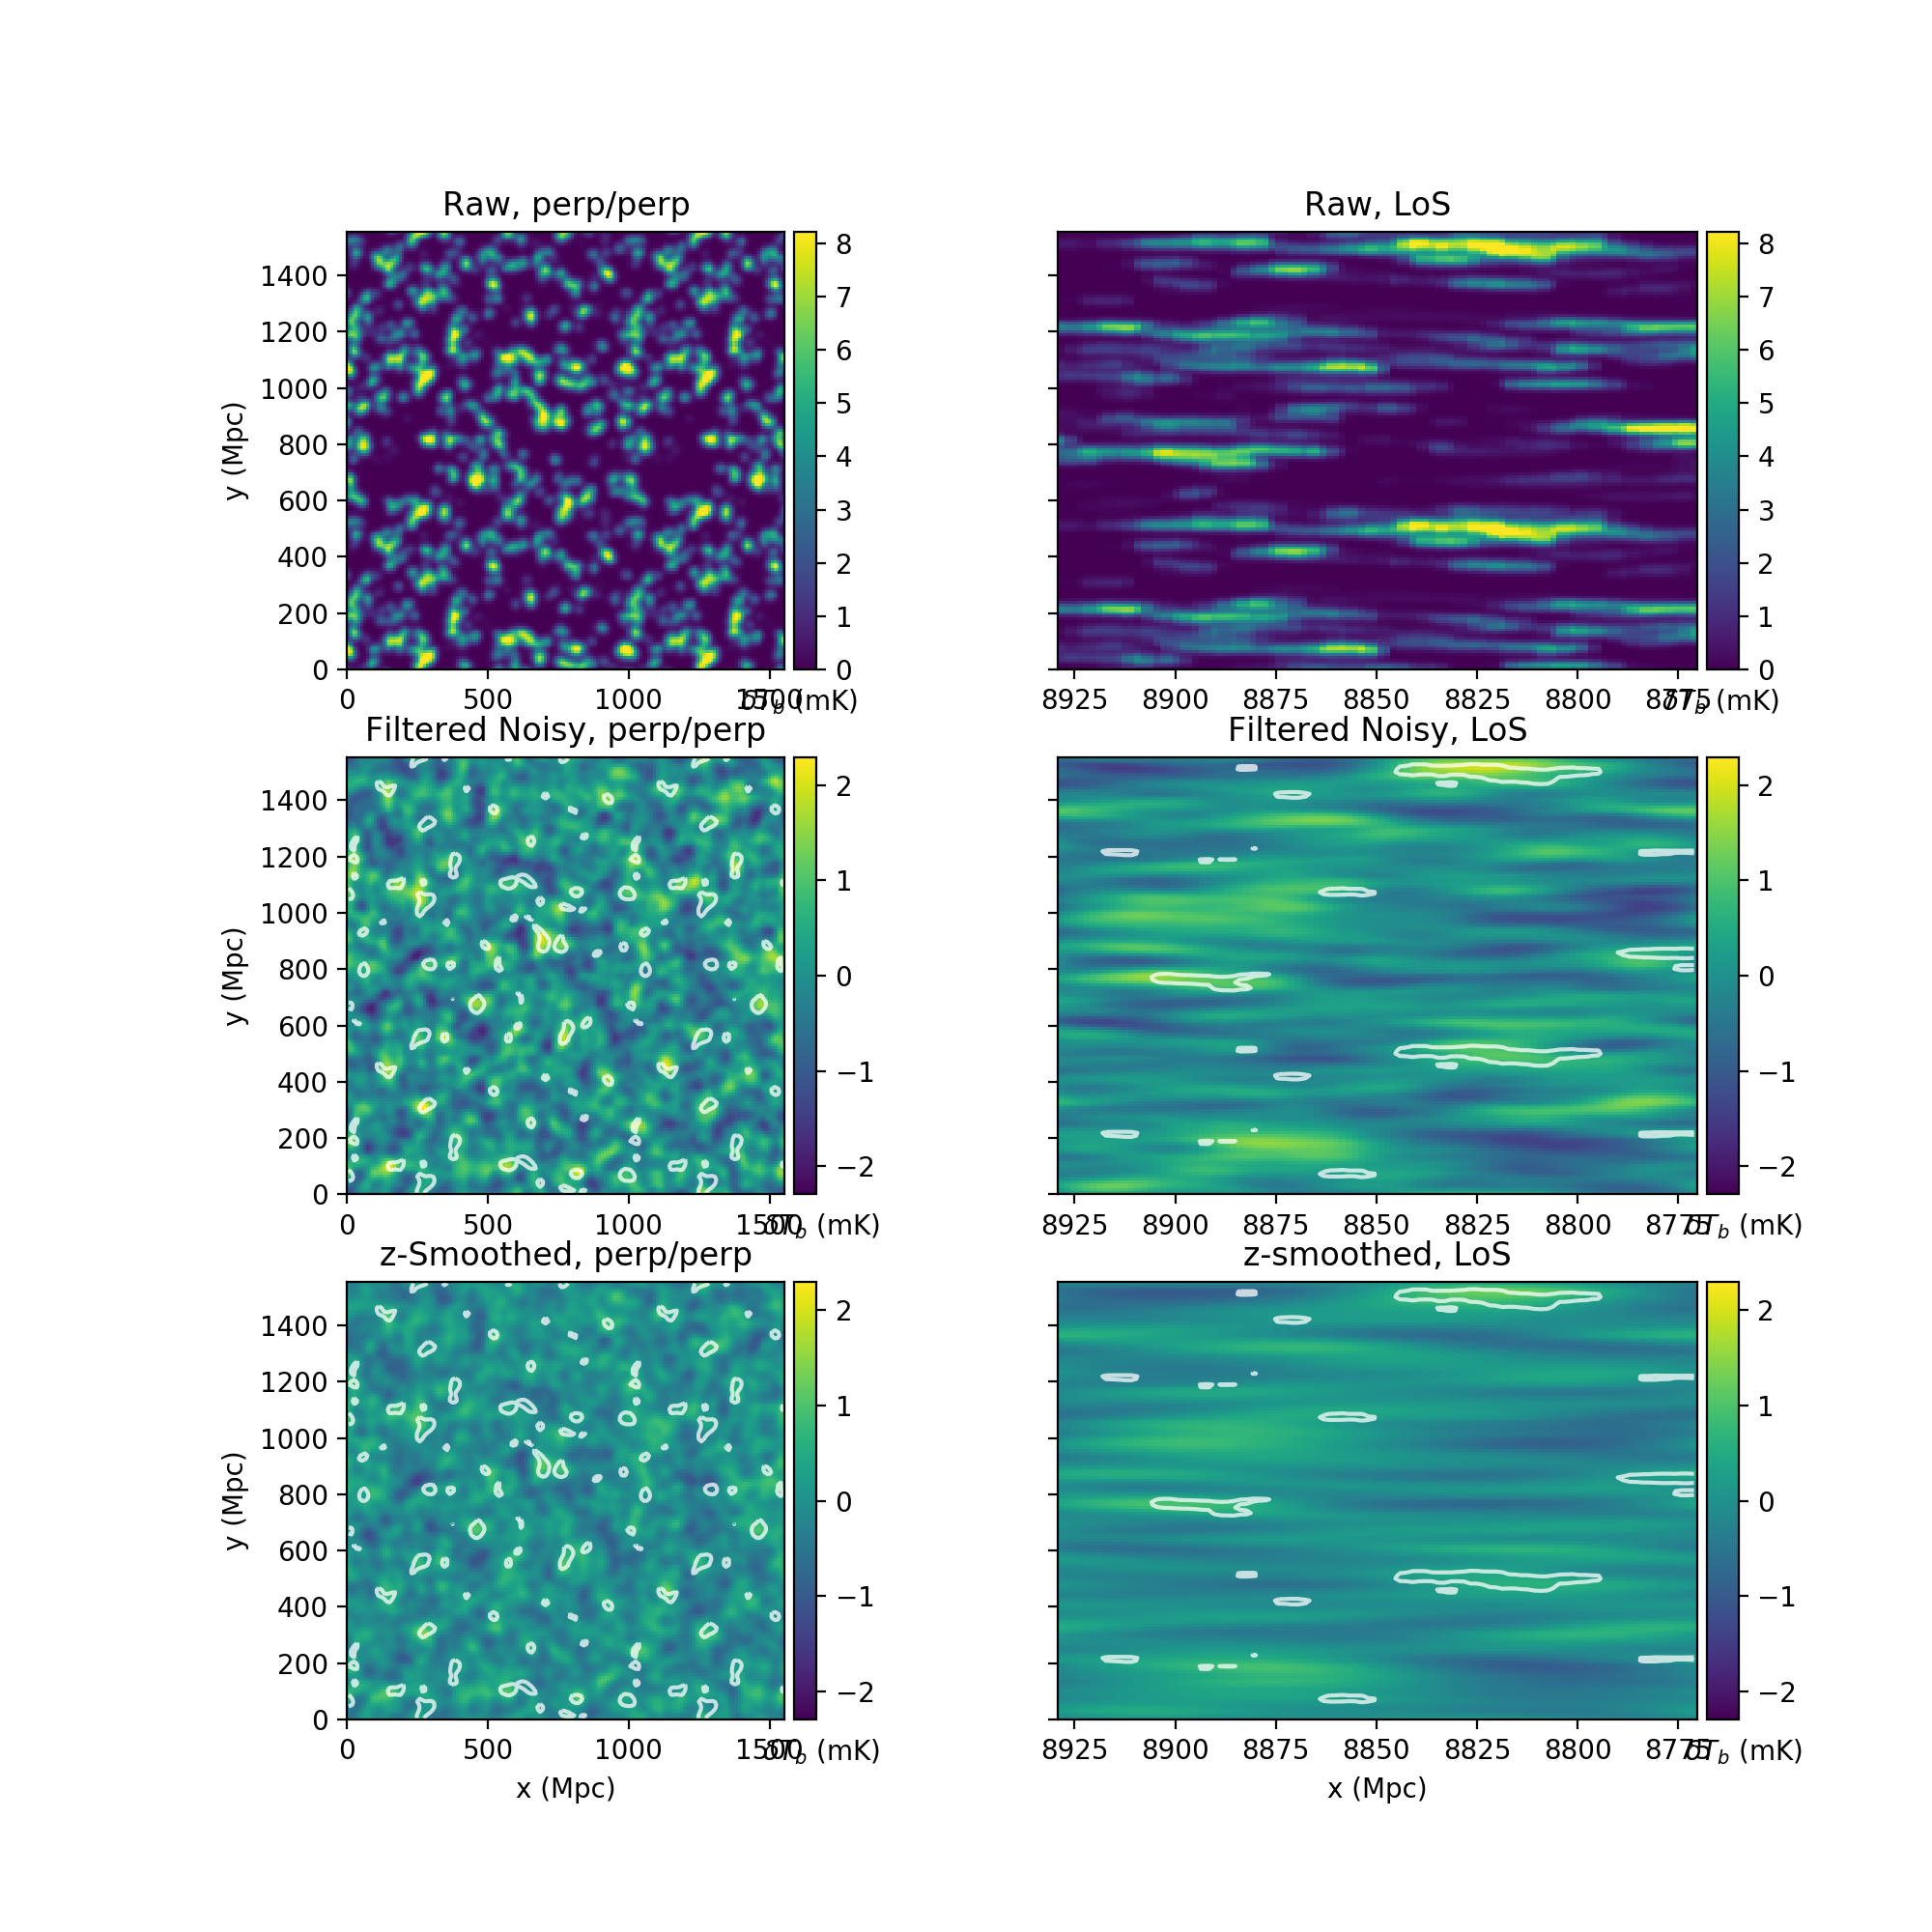

In [42]:
# Plot LoS Smoothed cube
cmap = cm.viridis
f, ax = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
vmax_raw = 0.7 * (tiled_cube).max()
vmax_filtered = 0.7 * (filtered_image + filtered_noise).max()
# vmax_smoothed = 0.7 * (filtered_smoothed).max()
vmax_smoothed = vmax_filtered
plot_contours = True
contour_alpha = 0.75
contour_levels = [0.7 * vmax_raw]
contour_colors = 'white'
contour_linewidths = 1.5

# perp perp cut, raw
i, j = (0, 0)
ind = tiled_cube.shape[2] / 2
ext = [obs_perpaxis[0], obs_perpaxis[-1], obs_perpaxis[0], obs_perpaxis[-1]]
im = ax[i][j].imshow(tiled_cube[:, :, ind], extent=ext, aspect='equal', cmap=cmap,
                     vmin=0, vmax=vmax_raw)
ax[i][j].set_ylabel('y (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Raw, perp/perp');

# perp perp cut, non-smoothed
i, j = (1, 0)
im = ax[i][j].imshow((filtered_image + filtered_noise)[:, :, ind], extent=ext, aspect='equal', cmap=cmap,
                     vmin=-vmax_filtered, vmax=vmax_filtered)
ax[i][j].set_ylabel('y (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Filtered Noisy, perp/perp');
if plot_contours:
    ax[i][j].contour(tiled_cube[:, :, ind], extent=ext, origin='upper', colors=contour_colors,
                     alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

# perp perp cut, smoothed
i, j = (2, 0)
im = ax[i][j].imshow(filtered_smoothed[:, :, ind], extent=ext, aspect='equal',
                     vmin=-vmax_smoothed, vmax=vmax_smoothed, cmap=cmap)
ax[i][j].set_ylabel('y (Mpc)')
ax[i][j].set_xlabel('x (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('z-Smoothed, perp/perp');
if plot_contours:
    ax[i][j].contour(tiled_cube[:, :, ind], extent=ext, origin='upper', colors=contour_colors,
                     alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

# LoS cut, raw
i, j = (0, 1)
ind = tiled_cube.shape[0] / 2
ext = [obs_zaxis[0], obs_zaxis[-1], obs_perpaxis[0], obs_perpaxis[-1]]
im = ax[i][j].imshow(tiled_cube[ind, :, :], extent=ext, aspect='auto', cmap=cmap,
                     vmin=0, vmax=vmax_raw)
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Raw, LoS');

# LoS cut, non-smoothed
i, j = (1, 1)
im = ax[i][j].imshow((filtered_image + filtered_noise)[ind, :, :], extent=ext, aspect='auto', cmap=cmap,
                     vmin=-vmax_filtered, vmax=vmax_filtered)
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Filtered Noisy, LoS');
if plot_contours:
    ax[i][j].contour(tiled_cube[ind, :, :], extent=ext, origin='upper', colors=contour_colors,
                     alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

# LoS, smoothed
vmax = 0.7 * (filtered_smoothed).max()
i, j = (2, 1)
im = ax[i][j].imshow(filtered_smoothed[ind, :, :], extent=ext, aspect='auto',
                     vmin=-vmax_smoothed, vmax=vmax_smoothed, cmap=cmap)
ax[i][j].set_xlabel('x (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('z-smoothed, LoS');
if plot_contours:
    ax[i][j].contour(tiled_cube[ind, :, :], extent=ext, origin='upper', colors=contour_colors,
                     alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)


# plt.savefig(plotdir + 'Images_zsmoothed_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(int(ndays)) + '_days.pdf')
plt.savefig(plotdir + 'Images_zsmoothed_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(ndays) + '_days.pdf')

In [32]:
# Get noise levels to plot SNR
noise_filtered = np.std(filtered_noise)
noise_smoothed = np.std(filters.gaussian_filter1d(filtered_noise, smooth_scale / dz, axis=2, mode='wrap'))

<IPython.core.display.Javascript object>


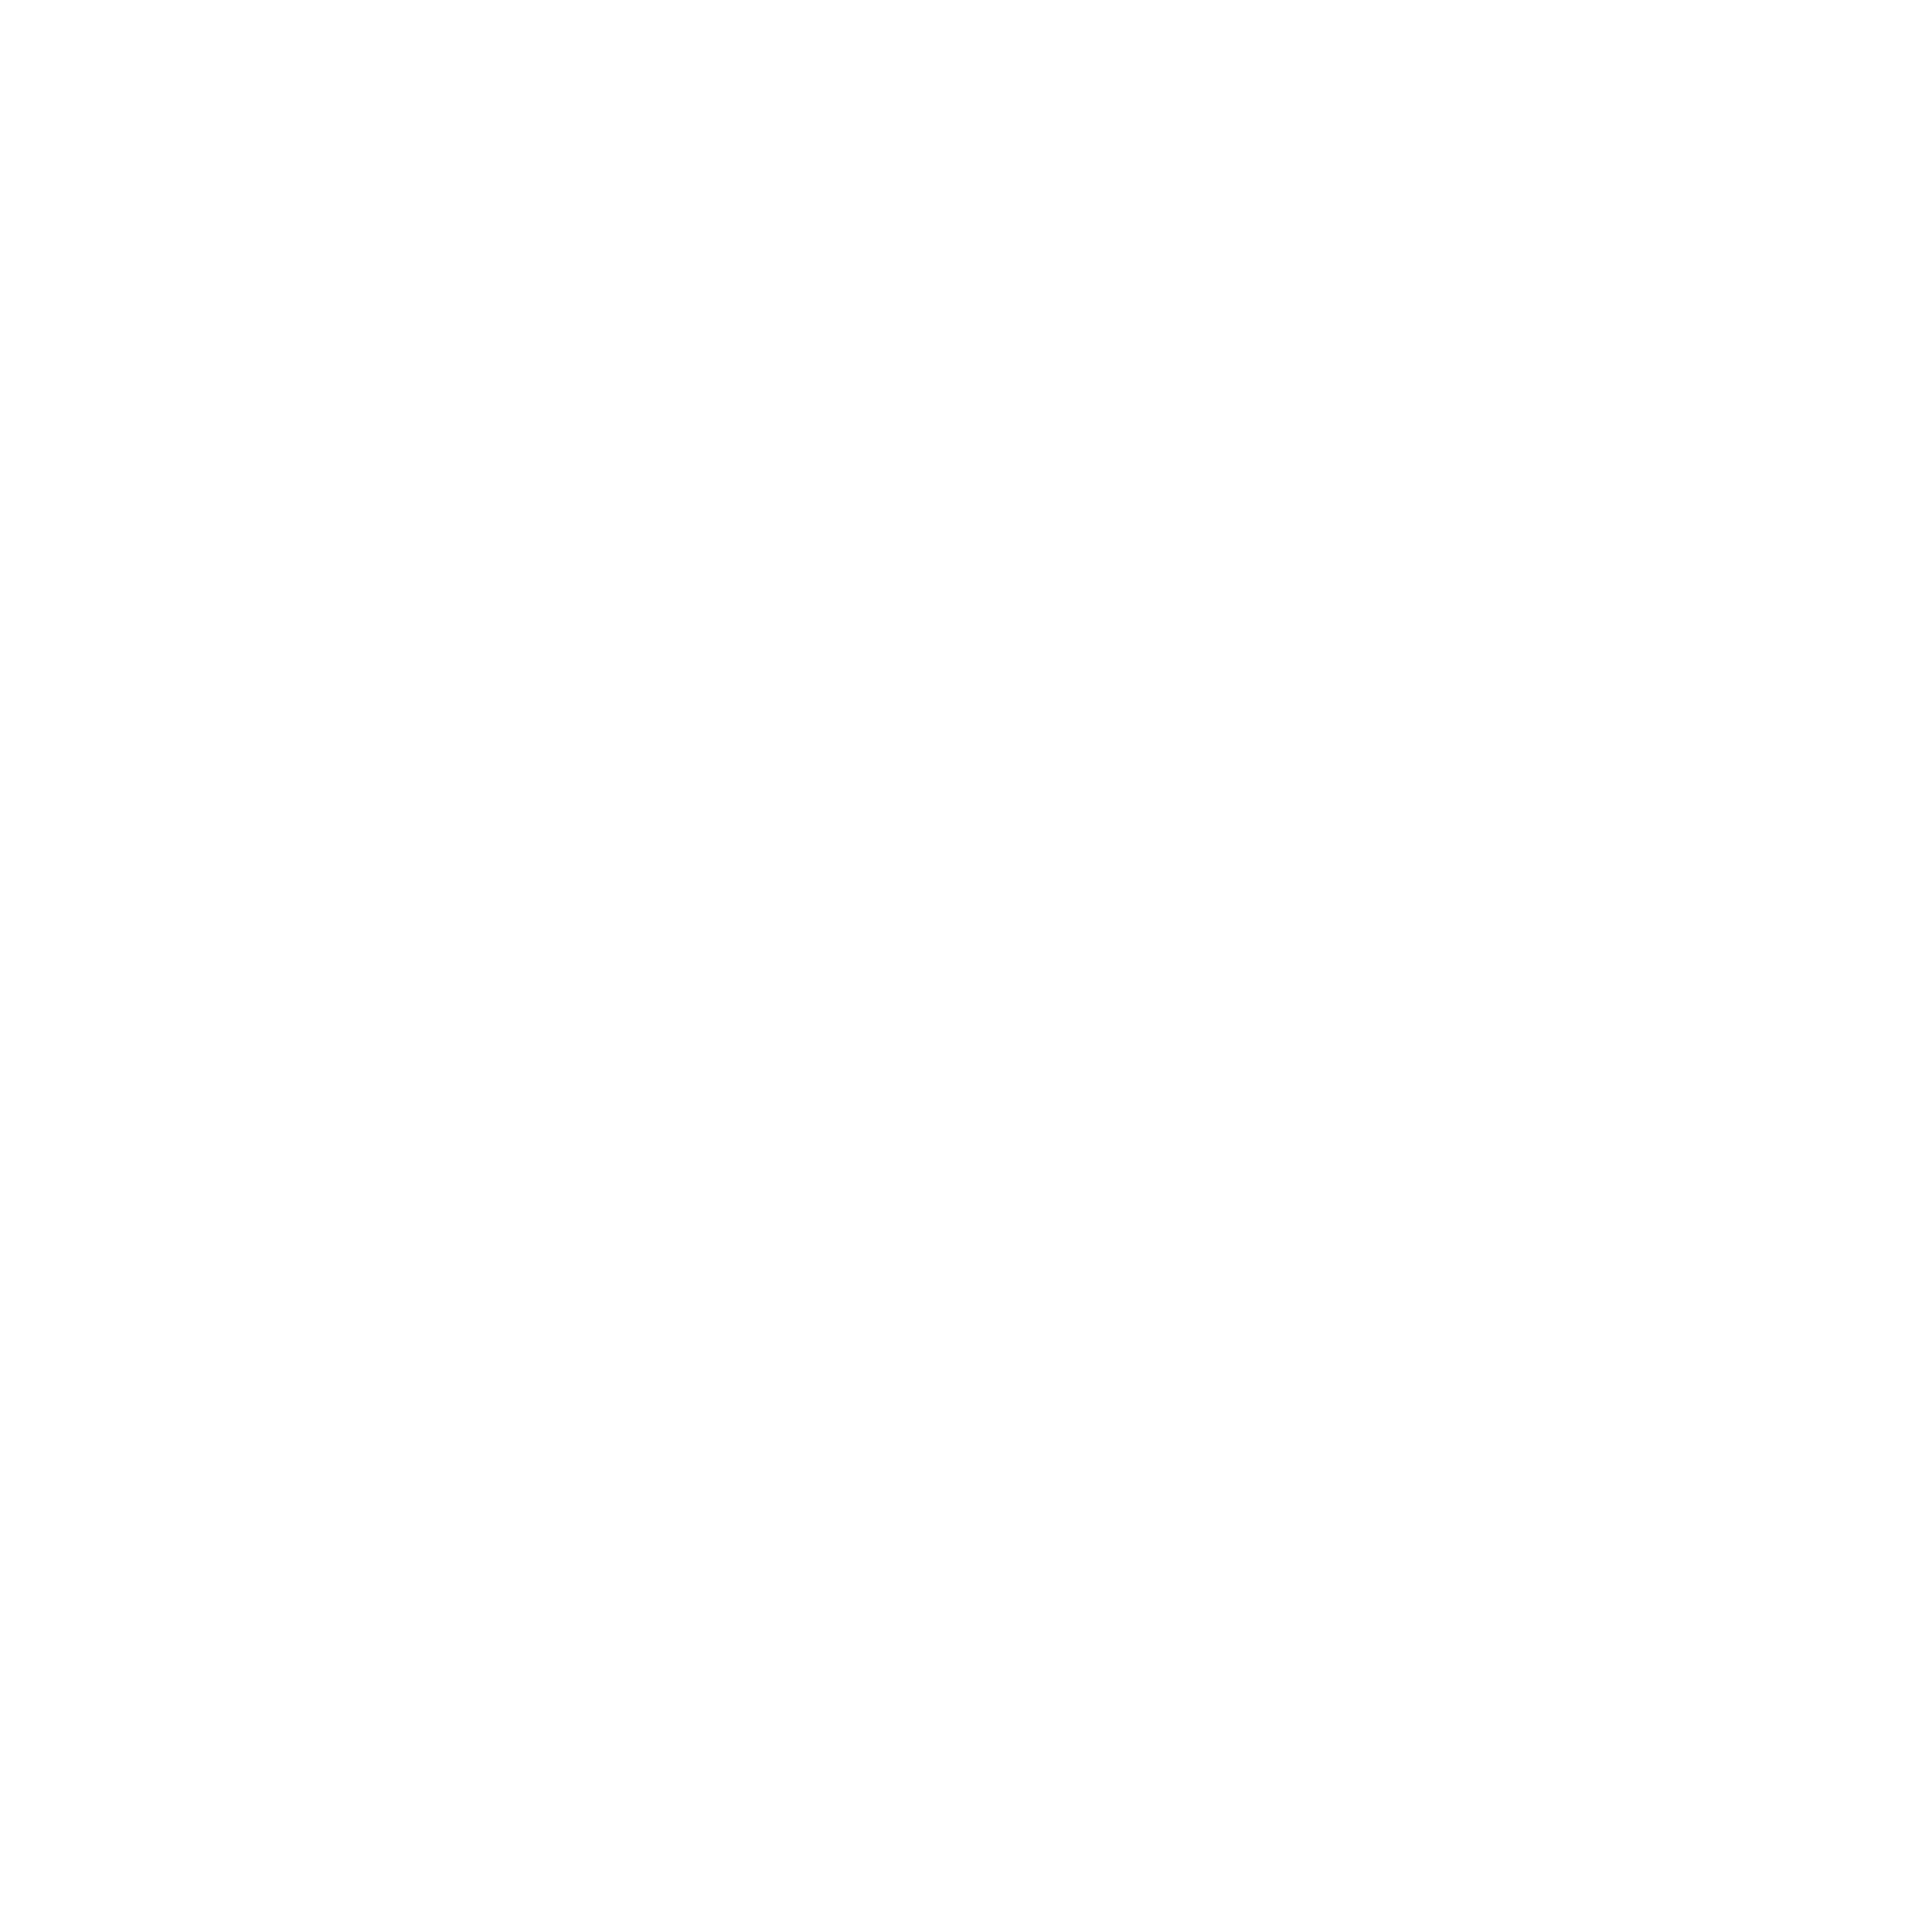

In [33]:
# Plot SNR for filtered and smoothed; raw Tb for ref
cmap = cm.viridis
f, ax = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
vmax_raw = 0.7 * (tiled_cube).max()
vmax_filtered = 0.7 * (filtered_image + filtered_noise).max() / noise_filtered
# vmax_smoothed = 0.7 * (filtered_smoothed).max()
vmax_smoothed = vmax_filtered

# perp perp cut, raw
i, j = (0, 0)
ind = tiled_cube.shape[2] / 2
ext = [obs_perpaxis[0], obs_perpaxis[-1], obs_perpaxis[0], obs_perpaxis[-1]]
im = ax[i][j].imshow(tiled_cube[:, :, ind], extent=ext, aspect='equal', cmap=cmap,
                     vmin=0, vmax=vmax_raw)
ax[i][j].set_ylabel('y (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Raw, perp/perp');

# perp perp cut, non-smoothed
i, j = (1, 0)
im = ax[i][j].imshow((filtered_image + filtered_noise)[:, :, ind] / noise_filtered, extent=ext, aspect='equal', cmap=cmap,
                     vmin=-vmax_filtered, vmax=vmax_filtered)
ax[i][j].set_ylabel('y (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('SNR', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Filtered Noisy, perp/perp');
if plot_contours:
    ax[i][j].contour(tiled_cube[:, :, ind], extent=ext, origin='upper', colors=contour_colors,
                     alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

# perp perp cut, smoothed
i, j = (2, 0)
im = ax[i][j].imshow(filtered_smoothed[:, :, ind] / noise_smoothed, extent=ext, aspect='equal',
                     vmin=-vmax_smoothed, vmax=vmax_smoothed, cmap=cmap)
ax[i][j].set_ylabel('y (Mpc)')
ax[i][j].set_xlabel('x (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('SNR', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('z-Smoothed, perp/perp');
if plot_contours:
    ax[i][j].contour(tiled_cube[:, :, ind], extent=ext, origin='upper', colors=contour_colors,
                     alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

# LoS cut, raw
i, j = (0, 1)
ind = tiled_cube.shape[0] / 2
ext = [obs_zaxis[0], obs_zaxis[-1], obs_perpaxis[0], obs_perpaxis[-1]]
im = ax[i][j].imshow(tiled_cube[ind, :, :], extent=ext, aspect='auto', cmap=cmap,
                     vmin=0, vmax=vmax_raw)
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Raw, LoS');

# LoS cut, non-smoothed
i, j = (1, 1)
ext = [obs_zaxis[0], obs_zaxis[-1], obs_perpaxis[0], obs_perpaxis[-1]]
im = ax[i][j].imshow((filtered_image + filtered_noise)[ind, :, :] / noise_filtered, extent=ext, aspect='auto', cmap=cmap,
                     vmin=-vmax_filtered, vmax=vmax_filtered)
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('SNR', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('Filtered Noisy, LoS');
if plot_contours:
    ax[i][j].contour(tiled_cube[ind, :, :], extent=ext, origin='upper', colors=contour_colors,
                     alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

# LoS, smoothed
vmax = 0.7 * (filtered_smoothed).max()
i, j = (2, 1)
im = ax[i][j].imshow(filtered_smoothed[ind, :, :] / noise_smoothed, extent=ext, aspect='auto',
                     vmin=-vmax_smoothed, vmax=vmax_smoothed, cmap=cmap)
ax[i][j].set_xlabel('x (Mpc)')
divider = make_axes_locatable(ax[i][j])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('SNR', labelpad=-20, y=-0.04, rotation=0)
ax[i][j].set_title('SNR, LoS');
if plot_contours:
    ax[i][j].contour(tiled_cube[ind, :, :], extent=ext, origin='upper', colors=contour_colors,
                     alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

# plt.savefig(plotdir + 'SNR_zsmoothed_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + str(int(ndays)) + '_days.pdf')
plt.savefig(plotdir + 'SNR_zsmoothed_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + str(ndays) + '_days.pdf')

In [34]:
# Make correlation plots
nbins_meas = 13
nbins_raw = 30
corr_noiseless = np.zeros((nbins_meas, nbins_raw))
corr_noisy = np.zeros((nbins_meas, nbins_raw))
corr_smoothed = np.zeros((nbins_meas, nbins_raw))

X, Y = np.meshgrid(xmap, xmap)
ref_cube = hybrid_cube[Y, X, :]

im = filtered_image.copy()
im = np.round((nbins_meas - 1) * (im - im.min()) / (im.max() - im.min()))
for val in range(nbins_meas):
    ind = np.where(im == val)
    if len(ind[0]) == 0:
        corr_noiseless[val, :] = np.nan
    else:
        subcube = ref_cube[(ind[0], ind[1], ind[2])]
        corr_noiseless[val, :] = np.histogram(ref_cube[(ind[0], ind[1], ind[2])],
                                              range=[ref_cube.min(), ref_cube.max()],
                                              bins=nbins_raw, density=True)[0]
        
im = (filtered_image + filtered_noise).copy()
im = np.round((nbins_meas - 1) * (im - im.min()) / (im.max() - im.min()))
for val in range(nbins_meas):
    ind = np.where(im == val)
    if len(ind[0]) == 0:
        corr_noisy[val, :] = np.nan
    else:
        subcube = ref_cube[(ind[0], ind[1], ind[2])]
        corr_noisy[val, :] = np.histogram(ref_cube[(ind[0], ind[1], ind[2])],
                                          range=[ref_cube.min(), ref_cube.max()],
                                          bins=nbins_raw, density=True)[0]
        
im = filtered_smoothed.copy()
im = np.round((nbins_meas - 1) * (im - im.min()) / (im.max() - im.min()))
for val in range(nbins_meas):
    ind = np.where(im == val)
    if len(ind[0]) == 0:
        corr_smoothed[val, :] = np.nan
    else:
        subcube = ref_cube[(ind[0], ind[1], ind[2])]
        corr_smoothed[val, :] = np.histogram(ref_cube[(ind[0], ind[1], ind[2])],
                                             range=[ref_cube.min(), ref_cube.max()],
                                             bins=nbins_raw, density=True)[0]

<IPython.core.display.Javascript object>


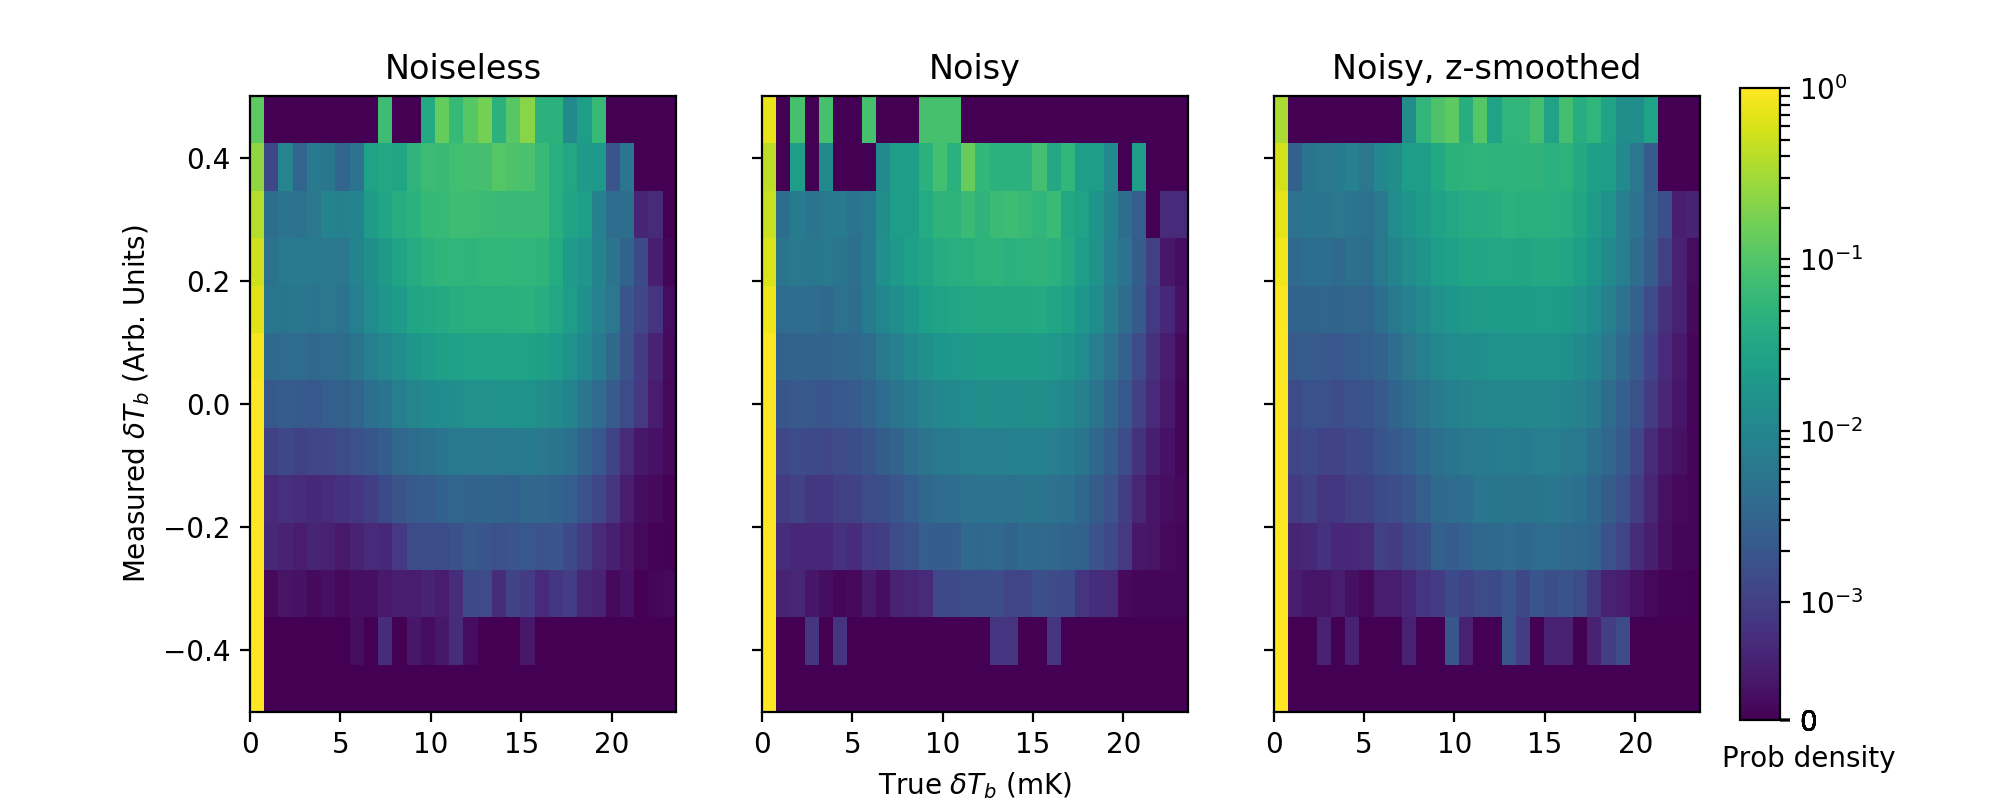

In [68]:
# Plot correlations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4), sharey=True)
ext = [ref_cube.min(), ref_cube.max(), -.5, .5]
im = axes[0].imshow(corr_noiseless, aspect='auto', norm=SymLogNorm(linthresh=1e-3, vmin=0, vmax=1.0),
                    extent=ext, origin='lower')
axes[0].set_title('Noiseless')
axes[0].set_ylabel('Measured $\delta T_b$ (Arb. Units)')
im = axes[1].imshow(corr_noisy, aspect='auto', norm=SymLogNorm(linthresh=1e-3, vmin=0, vmax=1.0),
                    extent=ext, origin='lower')
axes[1].set_xlabel('True $\delta T_b$ (mK)')
axes[1].set_title('Noisy')
im = axes[2].imshow(corr_smoothed, aspect='auto', norm=SymLogNorm(linthresh=1e-3, vmin=0, vmax=1.0),
                    extent=ext, origin='lower')
axes[2].set_title('Noisy, z-smoothed')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.1, 0.02, .79])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('Prob density', labelpad=-20, y=-0.04, rotation=0)

plt.savefig(plotdir + 'Correlations_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(ndays) + '_days.pdf')

In [70]:
print(corr_noisy.shape)
print(corr_noisy[0, 0])
print(corr_noisy[-1, 0])
print((ref_cube.max() - ref_cube.min()) / nbins_raw) * corr_noisy[0,0]

(13, 30)
1.27221091765
0.763326550588
1.0


<IPython.core.display.Javascript object>


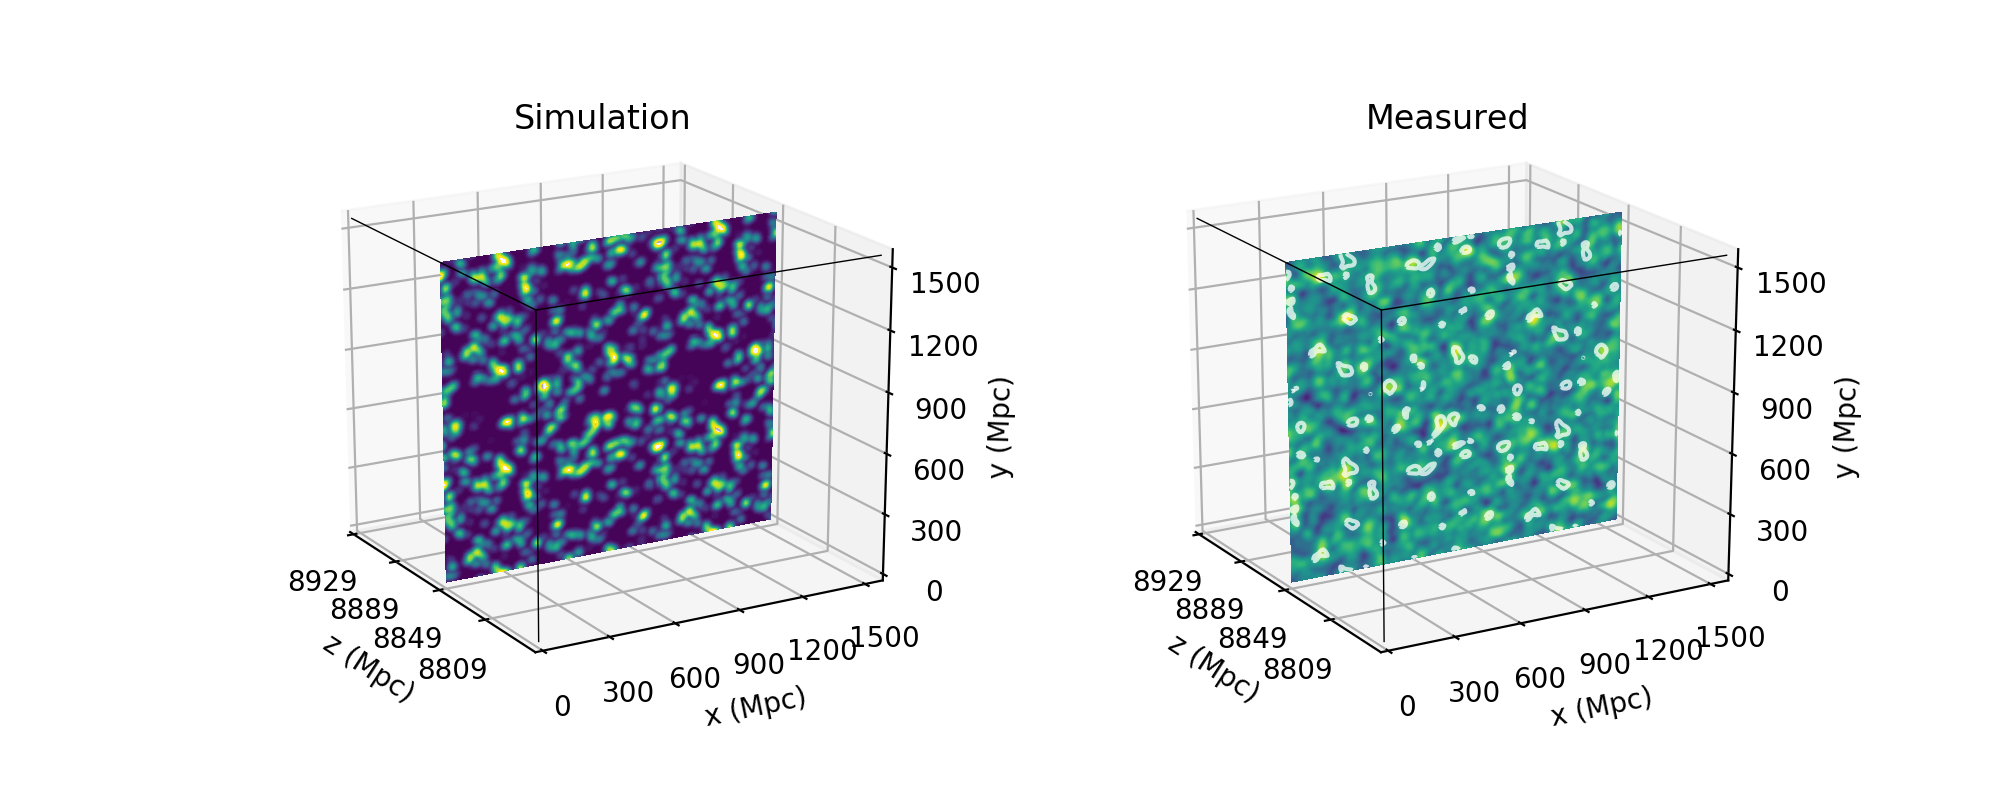

In [50]:
# 3D cube - plot slice
from mpl_toolkits.mplot3d import Axes3D
# plt.close('all')
fig = plt.figure(figsize=(10, 4))
vmax_raw = 0.7 * (tiled_cube).max()
vmax_filtered = 0.7 * (filtered_image + filtered_noise).max()

X, Y, Z = np.meshgrid(obs_zaxis, obs_perpaxis, obs_perpaxis, indexing='ij')
# im = filtered_smoothed.swapaxes(0, 2)
im = (filtered_image + filtered_noise).swapaxes(0, 2)
cim = tiled_cube.swapaxes(0, 2)

cset = [[], [], []]

ind = im.shape[0] / 2

## Reference cube
ax = fig.add_subplot(1, 2, 1, projection='3d')

cset[0] = ax.contourf(cim[ind, :, :], Y[ind, :, :], Z[ind, :, :], zdir='x', offset=X.mean(),
                      levels=np.linspace(0, vmax_raw, ncountours))

# Draw lines to distinguish faces
ax.plot([X.min(), X.min()], [Y.min(), Y.min()], [Z.min(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.max()], [Y.min(), Y.min()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.min()], [Y.min(), Y.max()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)

ax.set_xlim3d(X.max(), X.min())
ax.xaxis.set_ticks(np.arange(X.max(), X.min(), -40))
ax.set_xlabel('z (Mpc)')
ax.set_ylim3d(Y.min(), Y.max())
ax.yaxis.set_ticks(np.arange(0, 1600, 300))
ax.set_ylabel('x (Mpc)')
ax.set_zlim3d(Z.min(), Z.max())
ax.zaxis.set_ticks(np.arange(0, 1600, 300))
ax.set_zlabel('y (Mpc)')
ax.view_init(20, -30)
ax.set_title('Simulation')


ax = fig.add_subplot(1, 2, 2, projection='3d')
cset[0] = ax.contourf(im[ind, :, :], Y[ind, :, :], Z[ind, :, :], zdir='x', offset=X.mean(),
                      levels=np.linspace(-vmax_filtered, vmax_filtered, 100))

if plot_contours:
    ax.contour(cim[ind, :, :], Y[ind, :, :], Z[ind, :, :], zdir='x', offset=X.mean(),
               colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

# Draw lines to distinguish faces
ax.plot([X.min(), X.min()], [Y.min(), Y.min()], [Z.min(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.max()], [Y.min(), Y.min()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.min()], [Y.min(), Y.max()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)


ax.set_xlim3d(X.max(), X.min())
ax.xaxis.set_ticks(np.arange(X.max(), X.min(), -40))
ax.set_xlabel('z (Mpc)')
ax.set_ylim3d(Y.min(), Y.max())
ax.yaxis.set_ticks(np.arange(0, 1600, 300))
ax.set_ylabel('x (Mpc)')
ax.set_zlim3d(Z.min(), Z.max())
ax.zaxis.set_ticks(np.arange(0, 1600, 300))
ax.set_zlabel('y (Mpc)')
ax.view_init(20, -30)
ax.set_title('Measured')
plt.show()


<IPython.core.display.Javascript object>


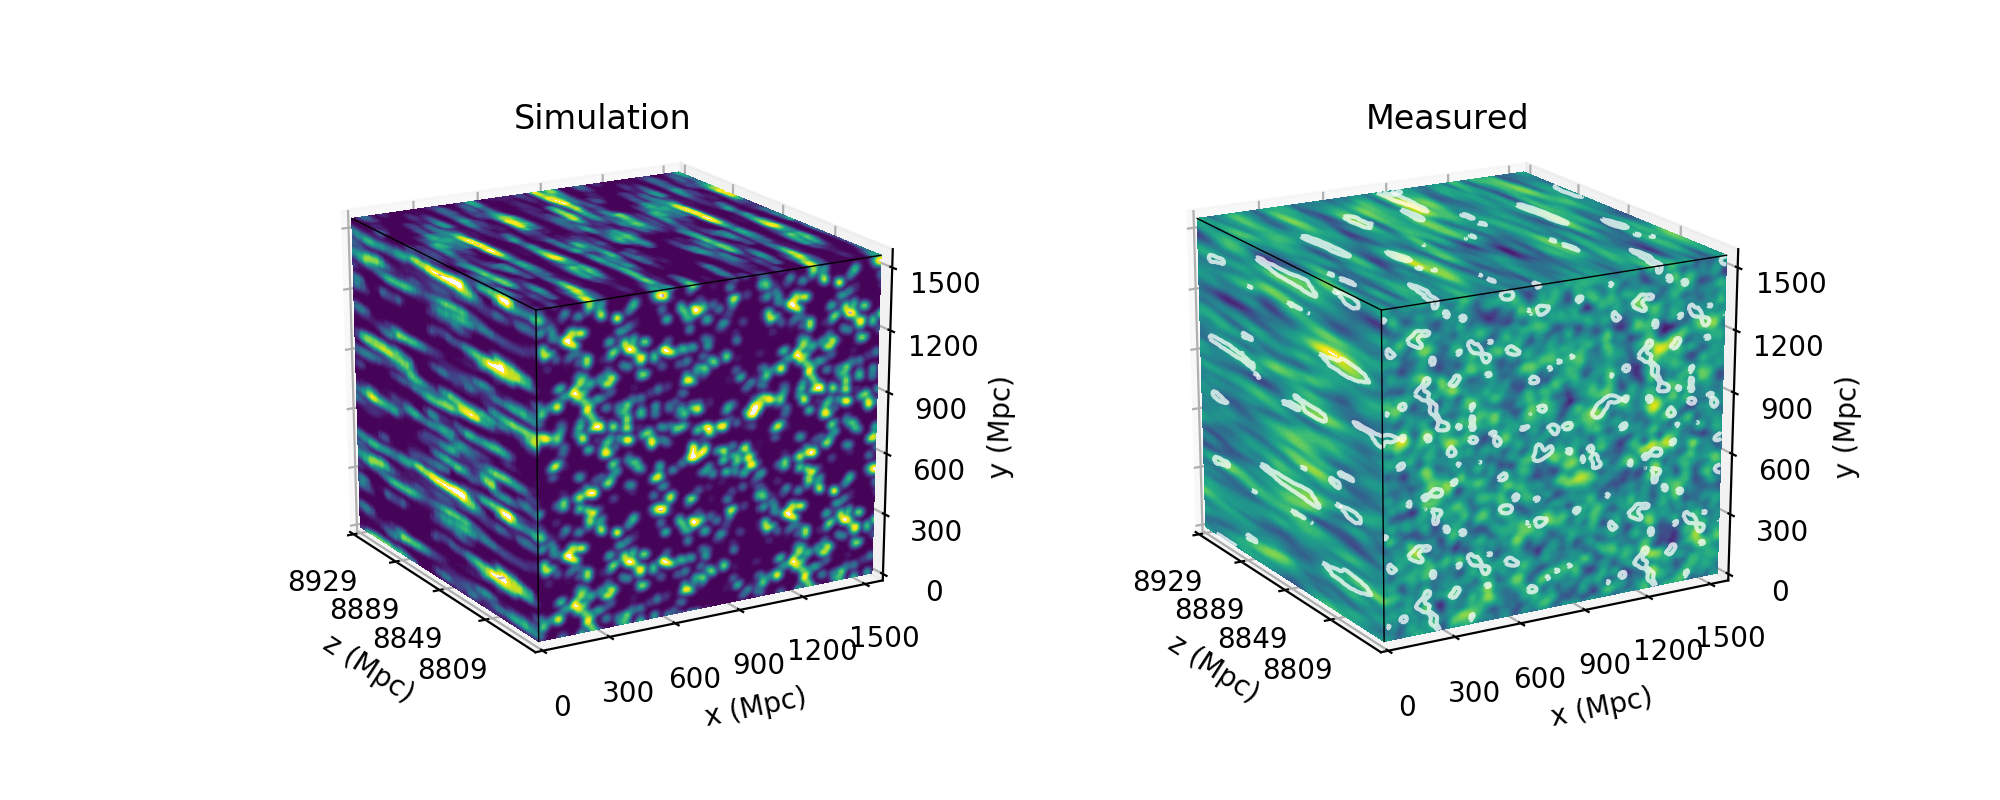

In [44]:
# 3D cube
from mpl_toolkits.mplot3d import Axes3D
# plt.close('all')
fig = plt.figure(figsize=(10, 4))
# ax = fig.gca(projection='3d')
vmax_raw = 0.7 * (tiled_cube).max()
vmax_filtered = 0.7 * (filtered_image + filtered_noise).max()
ncountours = 50

X, Y, Z = np.meshgrid(obs_zaxis, obs_perpaxis, obs_perpaxis, indexing='ij')
# im = filtered_smoothed.swapaxes(0, 2)
im = (filtered_image + filtered_noise).swapaxes(0, 2)
cim = tiled_cube.swapaxes(0, 2)

cset = [[], [], []]

## Reference cube
ax = fig.add_subplot(1, 2, 1, projection='3d')

cset[0] = ax.contourf(cim[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.min(),
                      levels=np.linspace(0, vmax_raw, ncountours))
cset[1] = ax.contourf(X[:, 0, :], cim[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                      levels=np.linspace(0, vmax_raw, ncountours))
cset[2] = ax.contourf(X[:, :, -1], Y[:, :, -1], cim[:, :, -1], zdir='z', offset=Z.max(),
                      levels=np.linspace(0, vmax_raw, ncountours))

# Draw lines to distinguish faces
ax.plot([X.min(), X.min()], [Y.min(), Y.min()], [Z.min(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.max()], [Y.min(), Y.min()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.min()], [Y.min(), Y.max()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)

ax.set_xlim3d(X.max(), X.min())
ax.xaxis.set_ticks(np.arange(X.max(), X.min(), -40))
ax.set_xlabel('z (Mpc)')
ax.set_ylim3d(Y.min(), Y.max())
ax.yaxis.set_ticks(np.arange(0, 1600, 300))
ax.set_ylabel('x (Mpc)')
ax.set_zlim3d(Z.min(), Z.max())
ax.zaxis.set_ticks(np.arange(0, 1600, 300))
ax.set_zlabel('y (Mpc)')
ax.view_init(20, -30)
ax.set_title('Simulation')

# Measured cube
ax = fig.add_subplot(1, 2, 2, projection='3d')

cset[0] = ax.contourf(im[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.min(),
                      levels=np.linspace(-vmax_filtered, vmax_filtered, ncountours))
cset[1] = ax.contourf(X[:, 0, :], im[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                      levels=np.linspace(-vmax_filtered, vmax_filtered, ncountours))
cset[2] = ax.contourf(X[:, :, -1], Y[:, :, -1], im[:, :, -1], zdir='z', offset=Z.max(),
                      levels=np.linspace(-vmax_filtered, vmax_filtered, ncountours))

if plot_contours:
    ax.contour(cim[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.min(),
               colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
    ax.contour(X[:, 0, :], cim[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
               colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
    ax.contour(X[:, :, -1], Y[:, :, -1], cim[:, :, -1], zdir='z', offset=Z.max(),
               colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

# Draw lines to distinguish faces
ax.plot([X.min(), X.min()], [Y.min(), Y.min()], [Z.min(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.max()], [Y.min(), Y.min()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.min()], [Y.min(), Y.max()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)


ax.set_xlim3d(X.max(), X.min())
ax.xaxis.set_ticks(np.arange(X.max(), X.min(), -40))
ax.set_xlabel('z (Mpc)')
ax.set_ylim3d(Y.min(), Y.max())
ax.yaxis.set_ticks(np.arange(0, 1600, 300))
ax.set_ylabel('x (Mpc)')
ax.set_zlim3d(Z.min(), Z.max())
ax.zaxis.set_ticks(np.arange(0, 1600, 300))
ax.set_zlabel('y (Mpc)')
ax.view_init(20, -30)
ax.set_title('Measured')
plt.savefig(plotdir + 'Images3D_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(ndays) + '_days.pdf')
plt.show()


<IPython.core.display.Javascript object>


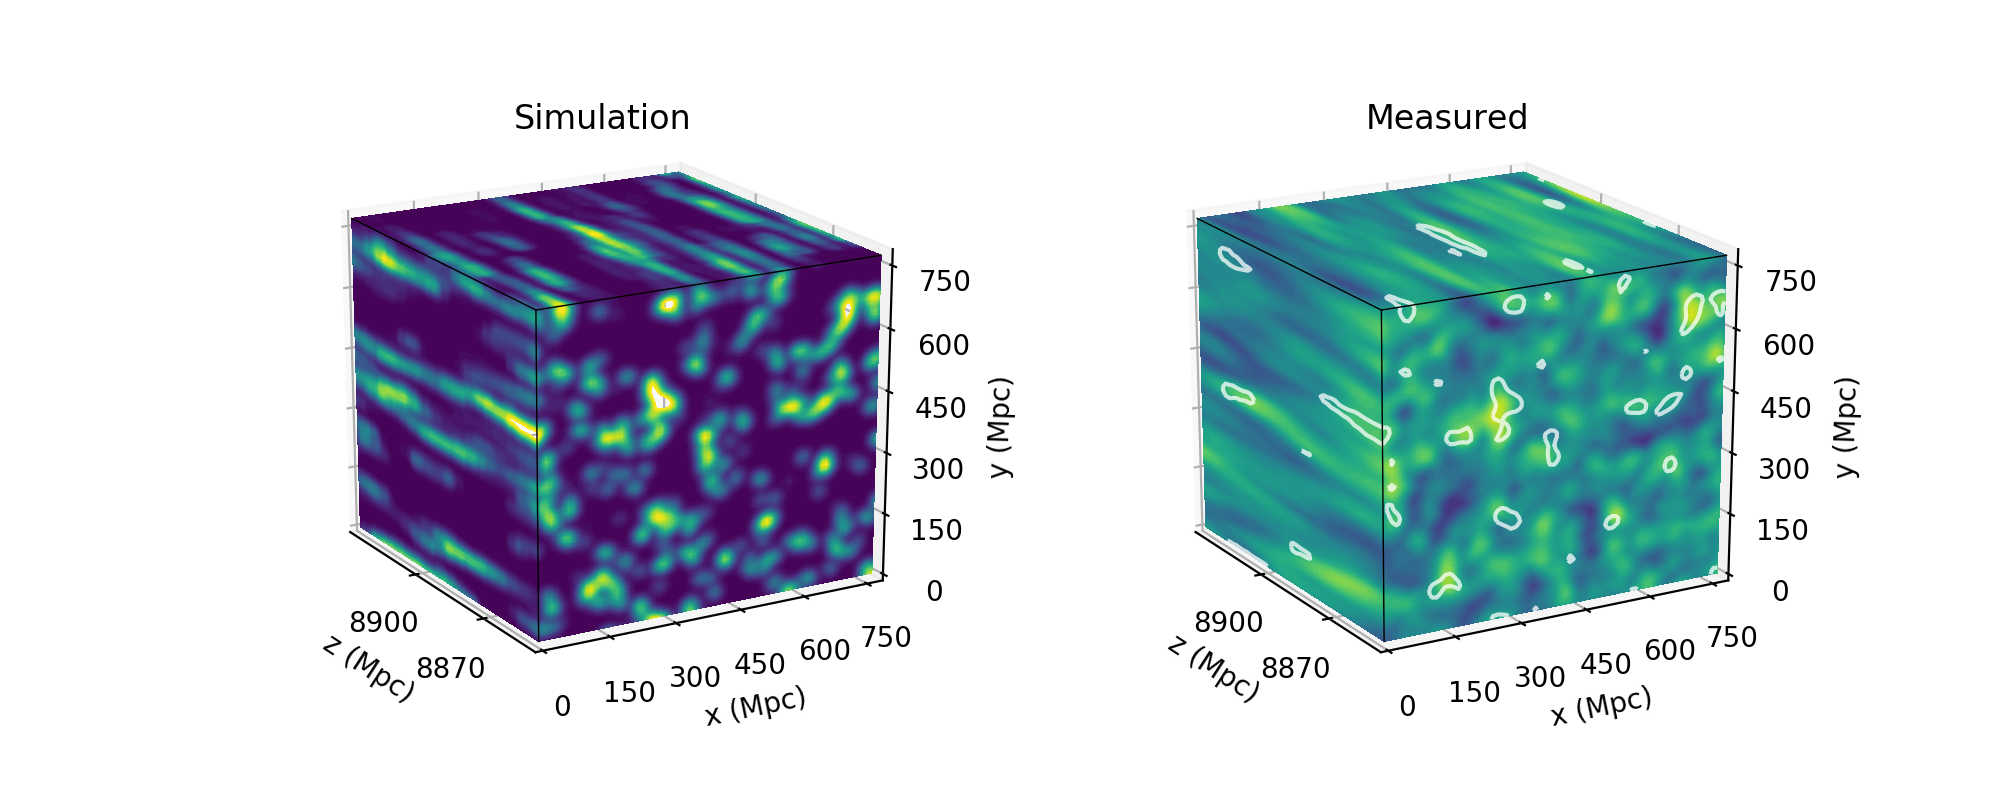

In [62]:
# 3D cube - zoomed
from mpl_toolkits.mplot3d import Axes3D
# plt.close('all')
fig = plt.figure(figsize=(10, 4))
# ax = fig.gca(projection='3d')
vmax_raw = 0.7 * (tiled_cube).max()
vmax_filtered = 0.7 * (filtered_image + filtered_noise).max()
ncountours = 50

X, Y, Z = np.meshgrid(obs_zaxis, obs_perpaxis, obs_perpaxis, indexing='ij')
# im = filtered_smoothed.swapaxes(0, 2)
im = (filtered_image + filtered_noise).swapaxes(0, 2)
cim = tiled_cube.swapaxes(0, 2)

# "zoom" image
im = im[:im.shape[0]/2, :im.shape[1]/2, :im.shape[2]/2]
cim = cim[:cim.shape[0]/2, :cim.shape[1]/2, :cim.shape[2]/2]
X = X[:im.shape[0], :im.shape[1], :im.shape[2]]
Y = Y[:im.shape[0], :im.shape[1], :im.shape[2]]
Z = Z[:im.shape[0], :im.shape[1], :im.shape[2]]

cset = [[], [], []]

## Reference cube
ax = fig.add_subplot(1, 2, 1, projection='3d')

cset[0] = ax.contourf(cim[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.min(),
                      levels=np.linspace(0, vmax_raw, ncountours))
cset[1] = ax.contourf(X[:, 0, :], cim[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                      levels=np.linspace(0, vmax_raw, ncountours))
cset[2] = ax.contourf(X[:, :, -1], Y[:, :, -1], cim[:, :, -1], zdir='z', offset=Z.max(),
                      levels=np.linspace(0, vmax_raw, ncountours))

# Draw lines to distinguish faces
ax.plot([X.min(), X.min()], [Y.min(), Y.min()], [Z.min(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.max()], [Y.min(), Y.min()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.min()], [Y.min(), Y.max()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)

ax.set_xlim3d(X.max(), X.min())
ax.xaxis.set_ticks(np.arange(round(X.max()/10)*10, round(X.min()/10)*10, -30))
ax.set_xlabel('z (Mpc)')
ax.set_ylim3d(Y.min(), Y.max())
ax.yaxis.set_ticks(np.arange(0, 800, 150))
ax.set_ylabel('x (Mpc)')
ax.set_zlim3d(Z.min(), Z.max())
ax.zaxis.set_ticks(np.arange(0, 800, 150))
ax.set_zlabel('y (Mpc)')
ax.view_init(20, -30)
ax.set_title('Simulation')

# Measured cube
ax = fig.add_subplot(1, 2, 2, projection='3d')

cset[0] = ax.contourf(im[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.min(),
                      levels=np.linspace(-vmax_filtered, vmax_filtered, ncountours))
cset[1] = ax.contourf(X[:, 0, :], im[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                      levels=np.linspace(-vmax_filtered, vmax_filtered, ncountours))
cset[2] = ax.contourf(X[:, :, -1], Y[:, :, -1], im[:, :, -1], zdir='z', offset=Z.max(),
                      levels=np.linspace(-vmax_filtered, vmax_filtered, ncountours))

if plot_contours:
    ax.contour(cim[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.min(),
               colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
    ax.contour(X[:, 0, :], cim[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
               colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
    ax.contour(X[:, :, -1], Y[:, :, -1], cim[:, :, -1], zdir='z', offset=Z.max(),
               colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

# Draw lines to distinguish faces
ax.plot([X.min(), X.min()], [Y.min(), Y.min()], [Z.min(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.max()], [Y.min(), Y.min()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)
ax.plot([X.min(), X.min()], [Y.min(), Y.max()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)


ax.set_xlim3d(X.max(), X.min())
ax.xaxis.set_ticks(np.arange(round(X.max()/10)*10, round(X.min()/10)*10, -30))
ax.set_xlabel('z (Mpc)')
ax.set_ylim3d(Y.min(), Y.max())
ax.yaxis.set_ticks(np.arange(0, 800, 150))
ax.set_ylabel('x (Mpc)')
ax.set_zlim3d(Z.min(), Z.max())
ax.zaxis.set_ticks(np.arange(0, 800, 150))
ax.set_zlabel('y (Mpc)')
ax.view_init(20, -30)
ax.set_title('Measured')
plt.savefig(plotdir + 'Images3D_zoomed_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(ndays) + '_days.pdf')
plt.show()


In [63]:
X.min()

8849.908986416569